# Práctica utilización de la librería Scikit learn
----
A lo largo de esta práctica se desarrollará un caso de uso que hace referencia a un **problema de clasificación multiclase**. Para abordar este caso de análisis se desarrollarán todas las etapas de lo que se conoce como el ciclo del dato para llegar a la etapa del modelado con modelos de Machine Learning que tratarán de clasificar de forma correcta determinados productos.

## Datos
---
Los datos se encuentraran divididos en lotes (lots). Cada lote corresponde a la subasta de un artículo. Dentro de cada directorio (lote) hay un archivo llamado data.json con la información de ese lote. 

Cada lote tiene asociado una categoría (category_l0) y subcategoría (category_l1). En esta práctica solo se trabará con las categorías: Jewellery & Watches, Antiques & Curio, Coins, Bullion & Stamps, Art y Books & Comics por ser las categorías con más muestras.

## Objetivos
---
Se pide crear uno o varios modelos predictivos o de clasificación. La lista de objetivos es la siguiente:

- (OA) Predecir el valor máximo de una subasta.
- (OB) Predecir el valor de la siguiente puja.
- (OC) Predecir los gastos de envío por país asociado a cada lote.
- (OD) Predecir el número de pujas que tendrá un lote.
- (OE) Predecir la subcategoria del lote.

A cada alumno además se le asignará una categoría sobre la que trabajar de las siguiente:

- (C1) Jewellery & Watches
- (C2) Antiques & Curio
- (C3) Coins, Bullion & Stamps
- (C4) Art
- (C5) Books & Comics

En nuestro caso, abordaremos el objetivo `OE` usando la categoría `C2`.


## Tareas
---
Para la realización de las tareas se deberá usar Scikit-learn, pandas y numpy.


## Preparación del conjunto de datos
----
Para llevar a cabo el entreniamiento de los modelos se tendrán que leer y seleccionar los datos correspondientes a la categoría asignada. 

Con estos datos se tendrá que crear un DataFrame de pandas.


## Limpieza y generación de nuevos atributos
----
En esta tarea se tendrán que seleccionar, hacer imputaciones de valores perdidos si es necesario y la generación de nuevos atributos que se consideren interesantes.


## Entrenamiento del modelo
----
Para llevar a cabo el entrenamiento del modelo se deberan escoger el(los) tipo(s) de algoritmo(s) apropiado(s) al objetivo, la métrica, dividir los datos según la técnicas de validación seleccionada y seleccionar los paŕametros más adecuados.


# Importación de las librerias necesarias
---

In [1]:
import os
from os import listdir
import os.path
import json
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import statistics
import math

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

**Nota:** Usaremos más librerias y funciones específicas a lo largo del proyecto que se irán indicando más adelante.

# Recopilación de la información
---

In [3]:
my_data=[]
ruta_path= '..\Parte IV\lots'
for archivo in os.listdir(ruta_path):
    file = json.loads(json.dumps(os.path.join(ruta_path, archivo, 'data.json')))
    if os.path.exists(file):
        with open(file, 'r') as fp:
            data = json.load(fp)
            
        if data['category_l0'] == 'Antiques & Curio':
            bids = data['bids'] # ofertas
            prices = [float(bids[i]['price']) for i in range(len(bids))]
            
            my_data.append({'sub_title': data['sub_title'], 'supplier_votes': data['supplier_votes'], 
                            'description': data['description'], 'auctioneer_names': data['auctioneer_names'], 
                            'id': data['id'], 'previous_bids': prices, 'title': data['title'], 
                            'meta_data': data['meta_data'], 'supplier_name': data['supplier_name'], 
                            'supplier_from': data['supplier_from'], 'shipping': data['shipping'], 
                            'supplier_country': data['supplier_country'], 'category_l0': data['category_l0'], 
                            'estimations': data['estimations'], 'likes': data['likes'], 
                            'supplier_score': data['supplier_score'], 'category_l1': data['category_l1']})
            
datos = pd.DataFrame(my_data) # data.frame creado con todos los datos para trabajar

**Comentarios** 

* En la construcción del data frame observamos que hemos creado la variable **prices**; dentro de la varible original **bids** (que se trata de un diccionario con claves y valores) nos resulta de interés construir el vector de pujas previas a un producto dado. Así pues, nos quedaremos únicamente con el valor de la clave *price* del diccionario de nombre *bids* y más adelante veremos como tratamos esta variable en nuestro análisis de clasificación.

* En la obtención de nuestro conjunto de datos observamos como hemos impuesto la categoría sobre la que trabajar, en nuestro caso: **Antiques & Curio**.


# Análisis exploratorio de los datos
---

## Presentación de los primeros registros y dimensiones del dataset
---

In [4]:
datos.head()

,auctioneer_names,category_l0,category_l1,description,estimations,id,likes,meta_data,previous_bids,shipping,sub_title,supplier_country,supplier_from,supplier_name,supplier_score,supplier_votes,title
0,[Roger Schreutelkamp],Antiques & Curio,Curio,\nA beautiful school poster by Isings on the c...,[],10000189,[],{},"[65.0, 60.0, 55.0, 50.0, 45.0, 40.0, 35.0, 30....","[[España, 15,00], [Alemania, 15,00], [Austria,...","The Netherlands 1960, J.B. Wolters Noordhoff G...",Nl,6 diciembre 2014,pauldevries23,100.0,310,"Beautiful intact, old linen history school pos..."
1,"[Francisco Álvarez Lloret, Mark van Gijsel]",Antiques & Curio,Curio,\nBeautiful old radio\n\nWorks very well! \n\n...,[],10000215,[],{},"[45.0, 40.0, 35.0, 30.0, 25.0, 20.0, 15.0, 10....","[[España, 28,00], [Alemania, 28,00], [Austria,...",Vintige radio 1980s,Nl,1 mayo 2015,old dutch,100.0,14,Vintige radio 1980s
2,[Roger Schreutelkamp],Antiques & Curio,Curio,\n5 educational school posters from 1973 by th...,[],10001397,[],{},"[40.0, 40.0, 35.0, 30.0, 25.0, 20.0, 15.0, 10....","[[España, 18,00], [Alemania, 18,00], [Austria,...",Year 1973,Fr,27 septiembre 2015,Clairvallon,97.0,35,"5 educational school posters, double sided"
3,[Christine Barrat],Antiques & Curio,Silver & Gold,\nSilver plated Christofle dish.Very good cond...,[],10002073,[],{},"[81.0, 76.0, 66.0, 61.0, 55.0, 50.0, 25.0, 20....","[[España, 15,00], [Alemania, 15,00], [Austria,...",Christofle dish,Fr,22 marzo 2015,Fabregas,100.0,5,Christofle dish
4,[Jeroen Zoetmulder],Antiques & Curio,Antiques,\n6 beautiful crystal wine glasses by Nachtman...,[],10004181,[],{},"[100.0, 100.0, 95.0, 90.0, 85.0, 80.0, 75.0, 7...","[[España, 19,00], [Alemania, 19,00], [Austria,...",In perfect condition.,Nl,15 enero 2015,AmazingAntiques,98.4,188,"6 crystal wine glasses Nachtmann, Germany, sec..."


In [5]:
datos.shape

(3479, 17)

Inicialmente nuestro conjunto de datos presenta 17 variables y 3479 registros (también llamados casos o individuos).

## Valores faltantes: *None*
---

En primer lugar, lo que deberíamos hacer es controlar si existen valores faltantes o nulos; esto lo podemos realizar utilizando el método *isnull()* del siguiente modo:

In [6]:
datos.isnull().any().any()

True

De acuerdo al resultado obtenido llegamos a que sí existen registros con valores faltantes lo cual nos llevará a tratarlos más adelante cuando realicemos un análisis variable a variable.

## Estudio de la variable objetivo
---

El objetivo de nuestro problema es predecir la subcateogría del lote; en nuestro dataframe, la variable que mide dicha característica es: *category_l1*

Un primer análisis exploratorio que se nos ocurre es conocer cuantos individuos de cada subcategoria tenemos, para ello realizamos lo siguiente:

In [7]:
print(datos.groupby('category_l1').size())

category_l1
Antiques                 308
Clocks                   101
Curio                   2048
Interior & Lifestyle      61
Lighters & Pens          191
Rugs & Carpets           437
Silver & Gold            333
dtype: int64


**Comentario:** la categoria "Curio" es la que presenta un mayor número de casos.

### Representación gráfica
---

Visualizamos este predominio de la subcategoría **Curio** con el siguiente diagrama de barras que nos permite ver la frecuencia (número de registros) de cada una de las subcategorías.

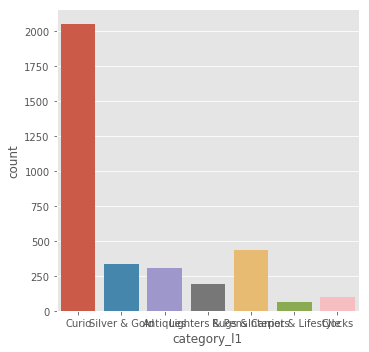

In [8]:
sb.catplot('category_l1', data = datos, kind="count")

# Preparación de los datos: limpieza y generación de nuevos atributos
---
## Imputación de valores perdidos (NaN)
---

A continuación llevaremos a cabo el trabajo de imputar los valores faltantes en las variables que posteriormente utilizaremos para nuestro análisis de clasificación. Dicha tarea es necesaria para poder llevar a cabo los diferentes algoritmos de aprendizaje supervisado pues los modelos no pueden trabajar con registros nulos; es cierto que algunos de los algoritmos empleados llevan consigo algún argumento que trata la existencias de valores None (registros faltantes). La manera de computar dichos valores es a elección del estadístico y dependiendo del trabajo en cuestión. En nuestro trabajo llevaremos a cabo tres técnicas:

- Calcularemos la media y la desviación estandar de la variable en cuestión y construiremos el intervalo (mu-dev, mu+std) de manera que a los registros faltantes se le asignará un valor aleatorio dentro de este intervalo. Esta técnica es utilizada en estadística pues los valores que se introducen no producen demasiado ruido en la variable y, por tanto, no se resiente el algoritmo utilizado. Sin embargo, en las variables a analizar observaremos que la desviación estandar es un valor superior a la media de la variable, lo que indica que la variable presenta una alta variabilidad. En ese caso, usaremos el intervalo (0, mu+std) pues el extremo inferior del intervalo no puede ser negativo (pues las variables no toman valores inferiores a 0).

- Otra opción de imputar los registros faltantes es reemplazar estos valores por el valor promedio. Esta técnica será usada en otra de las variables de interés de nuestro trabajo.

- Cuando trabajamos con un set de datos con un número de observaciones elevado y el número de valores nulos que presenta una variable no es muy alto, otra herramienta a utilizar es eliminar dichas observaciones de nuestro set de datos. Así, reduciremos nuestro conjunto de observaciones.

- Un análisis distinto es cuando trabajemos con la variable categórica *supplier_country*; en ese caso, tomaremos el listado de países presentes y asignaremos a los valores faltantes uno de ellos de manera aleatoria.


## Variable *previous_bids*
---
Observamos que la variable *previous_bids* es una lista de elementos cada uno de los cuales hace referencia a una puja previa. Nuestra tarea va a ser construir el vector de pujas medias de cada producto (lote).

Atendiendo a dicha variable, vemos que hay observaciones que presentan una lista [] en dicha variable haciendo referencia
a que no hay pujas previas, para nuestro análisis, a dichas observaciones le daremos el valor *None*, y posteriormente asignaremos un valor aleatorio (cumpliendo ciertas condiciones) a dichos registros faltantes.

Para quellas observaciones que presenten una lista de pujas, calcularemos la puja media de dichas pujas previas.

In [9]:
a = []
for k in range(datos.shape[0]):
    b = datos.loc[k, 'previous_bids']
    a.append(b)
a

d = []
for i in range(len(a)):
    if len(a[i]) > 1:
        c = statistics.mean(a[i])
        d.append(c)
    else:
        if len(a[i]) == 1:
            c = a[i][0]
            d.append(c)
        else:
            c = None
            d.append(c)
d

df = {'mean_bids': d} # creamos la nueva variable: mean_bids (la media de las pujas previas)
df = pd.DataFrame(df)

my_df_new = pd.concat([datos, df], axis=1)

A continuación llevaremos a cabo la imputación de los registros faltantes. Para ello en primer lugar necesitamos conocer el número de valores nulos presentes en nuestra variable a estudiar:

In [10]:
mb_avg = df.mean()
mb_std = df.std()
mb_null_count = df.isnull().sum()
mb_null_count

mean_bids    26
dtype: int64

**Explicación:** la desviación estandar, `std()`, es un promedio de las desviaciones individuales de cada observación con respecto a la media de una distribución. Así, la desviación estándar mide el grado de dispersión o variabilidad. La forma de calcularla manualmente atendiendo a su definición es de la siguiente manera:

In [11]:
std = math.sqrt((abs(df-df.mean())**2).mean())
print(" La desviación estándar de la variables es: {0} \n El valor promedio de la variable es: {1}".format(std, mb_avg))

 La desviación estándar de la variables es: 76.29507643981178 
 El valor promedio de la variable es: mean_bids    60.531827
dtype: float64


* ¿Cúal es el valor máximo y minimo que toma nuestra variable en cuestión?

In [12]:
print("El valor máximo de la variable es {0} y el valor mínimo {1}".format(df['mean_bids'].max(), df['mean_bids'].min()))

El valor máximo de la variable es 606.8 y el valor mínimo 1.0


Como comentamos en el inicio de esta sección; no tiene sentido construir el intervalo (mu-std,mu+std) pues estaríamos dando la posibilidad de asignar valores negativos a una variable que no lo admite. Este comportamiento se obtiene pues nuestra variable *mean_bids* es una variable que presenta una alta variabilidad. De esta manera, asignaremos pujas aleatorias a los registros faltantes dentro del intervalo (1,136.837954). El extremo inferior se debe a que hemos calculado que el valor mínimo que toma esa variable en nuestros datos es igual a 1. Así, la inclusión de estos nuevos valores no introduce cambios muy significativos en análisis posteriores (son un rango de valores frecuente en la variable estudiada).

* **Contruimos el vector de dimensión *mb_null_count* (número de observaciones *None*) con valores pertenecientes al intervalo dicho y asociamos a cada uno de los valores faltantes uno de dichos valores:**

In [13]:
np.random.seed(666) # fijamos una semilla
mb_null_random_list = np.random.randint(1, mb_std + mb_avg, size=mb_null_count)
 
conValoresNulos = pd.isnull(my_df_new['mean_bids'])

my_df_new.loc[pd.isnull(my_df_new['mean_bids']), 'mean_bids'] = mb_null_random_list

In [14]:
my_df_new['mean_bids'].isnull().sum()

0

> `mb_null_random_list` tiene 26 valores aleatorios (fijados por una semilla) que son asignados a cada valor *None* de la variable `mean_bids` (el primer elemento de `mb_null_random_list` se asocia al primer registro faltante, el segundo elemento aleatorio con el segundo valor *None*, etc.). Observamos por tanto que ya no tenemos valores faltantes, pues los 26 registros nulos han sido sustituidos por un valor comprendido entre 1 y 136.837954.

## Variable *supplier_country*
---
Observamos que dicha variable hace referencia al pais del proveedor (variable de tipo carácter) y presenta ciertos valores [], luego definiremos una función que nos permita transformar dichos valores por valores faltantes *None*.

In [15]:
def funcion(country):
    if len(country)==0:
        return None
    return country
 
my_df_new['supplier_country']=my_df_new.apply(lambda x: funcion(x['supplier_country']), axis=1);

En este caso, el tratamiento de los valores faltantes será asignar a los mismos algún país ya presente en nuestras observaciones. Para ello, debemos crear la lista de países existentes y asignar, de manera aleatoria, uno de estos paises a las observaciones faltantes.

* Vemos en primer lugar qué países tenemos en nuestro análisis y construimos una lista con los mismos:

In [16]:
a = [my_df_new['supplier_country'][i] for i in range(my_df_new.shape[0])]

# Creamos la lista de los países (elimnando los objetos repetidos de a)
lista_nueva = []
for i in a:
    if i not in lista_nueva:
        lista_nueva.append(i)
lista_nueva

lista = [x for x in lista_nueva if x is not None] # eliminamos el valor None de la lista de países
lista

['Nl',
 'Fr',
 'At',
 'Es',
 'Be',
 'Ua',
 'De',
 'It',
 'Pl',
 'Hu',
 'Pt',
 'Ee',
 'Gb',
 'Lt',
 'Ro',
 'Tr',
 'Dk',
 'Se',
 'Il',
 'Am',
 'Ca',
 'Bg',
 'Us',
 'Ch',
 'No',
 'Gr',
 'Id',
 'Cz',
 'Sa',
 'Ie',
 'Ma',
 'Sg',
 'Rs',
 'Hk']

* ¿Cuántos valores *None* presenta la variable *supplier_country*?

In [17]:
sc_null_count = my_df_new['supplier_country'].isnull().sum()
sc_null_count

56

* **Creamos ahora la lista de tamaño *sc_null_count* que consta de los paises, escogidos de manera aleatoria, presentes en la lista previamente creada y asociamos a cada valor *None* uno de estos valores:**

In [18]:
import random

np.random.seed(666) # fijamos la semilla
sc_null_random_list = np.random.choice(lista, size=sc_null_count) 
# crear un conjunto de valores de manera aleatoria de la lista de paises y tamaño número de registros faltantes
sc_null_random_list

array(['At', 'Ma', 'De', 'Hu', 'Ma', 'Cz', 'Ma', 'Sg', 'Sa', 'Ro', 'Hk',
       'Dk', 'Ua', 'Il', 'Gb', 'Tr', 'Lt', 'Ua', 'Ca', 'Ee', 'No', 'Ca',
       'Ma', 'Dk', 'Lt', 'Id', 'Ua', 'Hk', 'Nl', 'Ma', 'Nl', 'Cz', 'Ro',
       'Nl', 'Sa', 'Am', 'At', 'Cz', 'Us', 'Cz', 'Tr', 'Cz', 'Dk', 'Am',
       'Hu', 'Lt', 'At', 'No', 'Ch', 'Ee', 'It', 'Ca', 'Am', 'Bg', 'Ie',
       'Am'], dtype='<U2')

In [19]:
conValoresNulos = pd.isnull(my_df_new['supplier_country'])
 
# asociamos a cada registro nulo un elemento de la lista "sc_null_random_list", i.e, un pais de manera aleatoria
my_df_new.loc[pd.isnull(my_df_new['supplier_country']), 'supplier_country'] = sc_null_random_list

my_df_new['supplier_country'].head()

0    Nl
1    Nl
2    Fr
3    Fr
4    Nl
Name: supplier_country, dtype: object

Convertimos ahora la variable categórica a numérica y calculamos la frecuencia de cada país en nuestros datos de trabajo.

In [20]:
print(my_df_new.groupby('supplier_country').size())

my_df_new['supplier_country'] = my_df_new['supplier_country'].map({i:j for i,j in zip(lista, range(len(lista)))}).astype(int)

supplier_country
Am       6
At      17
Be     360
Bg       3
Ca       8
Ch       3
Cz       6
De     245
Dk       7
Ee       3
Es     177
Fr     277
Gb     116
Gr       6
Hk       3
Hu       8
Id       2
Ie       4
Il       5
It     337
Lt       6
Ma       7
Nl    1675
No       3
Pl      63
Pt      69
Ro      15
Rs       1
Sa       3
Se       3
Sg       2
Tr      15
Ua      16
Us       8
dtype: int64


## Variables *supplier_score* y *supplier_votes*
---
* *supplier_score*: puntuación del proveedor

* *supplier_votes*: votos del proveedor

Análizamos el comportamiento de dichas variables:

In [21]:
my_df_new[['supplier_votes']].isnull().any().any() # TRUE
my_df_new[['supplier_score']].isnull().any().any() # FALSE, sin embargo, hay casos donde observamos la []

## Observamos en el siguiente ejemplo este compartamiento
my_df_new.loc[21, ['supplier_name','supplier_score', 'supplier_votes']]

supplier_name     nfll
supplier_score      []
supplier_votes    None
Name: 21, dtype: object

**Interpretación:** vemos como el proveedor de nombre *nfll* no ha realizado ninguna puntuación al lote en cuestión mientras que no se ha registrado ningún voto a dicho producto.

**¿Cómo reaccionamos a este comportamiento?**

### Variable *supplier_votes*
---
En primer lugar, convertimos dicha variable a valores numéricos de tipo *float*:

In [22]:
my_df_new['supplier_votes'] = my_df_new['supplier_votes'].apply(pd.to_numeric)

* **Calculamos diversas características de dicha variable: media, desviación estándar, valor mínimo, valor máximo**

In [23]:
print(" Valor medio: {0} \n Desviación estándar: {1} \n Valor mínimo: {2} \n Valor máximo: {3}".
      format(my_df_new['supplier_votes'].mean(), my_df_new['supplier_votes'].std(), 
            my_df_new['supplier_votes'].min(), my_df_new['supplier_votes'].max()))

 Valor medio: 452.6391502276176 
 Desviación estándar: 953.1089450775765 
 Valor mínimo: 5.0 
 Valor máximo: 15844.0


Nos encontramos ante el caso de que la variable a analizar presenta una alta variabilidad (mayor valor de desviación estándar que de valor medio). Por lo tanto, no tiene sentido considerar el intervalo (mu-std, mu+std). En este caso, asignaremos a los registros faltantes el promedio de la variable de interés, solucionando así la existencia de valores fuera de rango así como la de valores nulos.

In [24]:
promedio = my_df_new['supplier_votes'].mean()
my_df_new['supplier_votes'] = my_df_new['supplier_votes'].replace(np.nan, promedio)

In [25]:
my_df_new['supplier_votes'].isnull().sum()

0

Tenemos por tanto que dicha variable ya no presenta valores faltantes.

### Variable *supplier_score*
---
En primer lugar transformamos las listas vacias en valores faltantes (*None*) de acuerdo a la función previamente creada:

In [26]:
my_df_new['supplier_score'] = my_df_new.apply(lambda x: funcion(x['supplier_score']), axis=1)

En este caso, el tratamiento que llevaremos a cabo para los valores nulos será la eliminación de estas observaciones.

In [27]:
my_df_new.dropna(subset=['supplier_score'], inplace=True)

my_df_new.shape[0]

3295

**Comentario:** pasamos a tener 3295 observaciones tras la eliminación de dichas observaciones (previamente teníamos un total de 3479).

Por último, convertimos dicha variable a una variable numérica de tipo *float*.

In [28]:
my_df_new['supplier_score'] = my_df_new['supplier_score'].apply(pd.to_numeric)

# Nuevo dataframe con los cambios efectuados
---
En primer lugar, eliminamos la variable `previous_bids` de nuestro conjunto de datos pues su información queda ahora almacenada en la variable creada `mean_bids` que presenta la puja media de las pujas previas del lote.

Además, la variable `supplier_country` pasa a ser una variable numérica donde cada número hace referencia a un país y donde los valores faltantes han sido imputados, de manera aleatoria, por un país ya existente. En cuanto a las variables `supplier_score` y `supplier_votes` ya vemos que no presentan ni valores nulos ni listas vacias.

In [29]:
new_data = my_df_new.drop('previous_bids', axis=1)
new_data

,auctioneer_names,category_l0,category_l1,description,estimations,id,likes,meta_data,shipping,sub_title,supplier_country,supplier_from,supplier_name,supplier_score,supplier_votes,title,mean_bids
0,[Roger Schreutelkamp],Antiques & Curio,Curio,\nA beautiful school poster by Isings on the c...,[],10000189,[],{},"[[España, 15,00], [Alemania, 15,00], [Austria,...","The Netherlands 1960, J.B. Wolters Noordhoff G...",0,6 diciembre 2014,pauldevries23,100.0,310.0,"Beautiful intact, old linen history school pos...",30.142857
1,"[Francisco Álvarez Lloret, Mark van Gijsel]",Antiques & Curio,Curio,\nBeautiful old radio\n\nWorks very well! \n\n...,[],10000215,[],{},"[[España, 28,00], [Alemania, 28,00], [Austria,...",Vintige radio 1980s,0,1 mayo 2015,old dutch,100.0,14.0,Vintige radio 1980s,16.250000
2,[Roger Schreutelkamp],Antiques & Curio,Curio,\n5 educational school posters from 1973 by th...,[],10001397,[],{},"[[España, 18,00], [Alemania, 18,00], [Austria,...",Year 1973,1,27 septiembre 2015,Clairvallon,97.0,35.0,"5 educational school posters, double sided",20.636364
3,[Christine Barrat],Antiques & Curio,Silver & Gold,\nSilver plated Christofle dish.Very good cond...,[],10002073,[],{},"[[España, 15,00], [Alemania, 15,00], [Austria,...",Christofle dish,1,22 marzo 2015,Fabregas,100.0,5.0,Christofle dish,26.526316
4,[Jeroen Zoetmulder],Antiques & Curio,Antiques,\n6 beautiful crystal wine glasses by Nachtman...,[],10004181,[],{},"[[España, 19,00], [Alemania, 19,00], [Austria,...",In perfect condition.,0,15 enero 2015,AmazingAntiques,98.4,188.0,"6 crystal wine glasses Nachtmann, Germany, sec...",47.705882
5,[Roger Schreutelkamp],Antiques & Curio,Curio,\n6 blackboards from the 1960s-1970s\nPrint He...,[],10005517,[],{},"[[España, 21,00], [Alemania, 21,00], [Austria,...",Mid 20th Century approximately 1960-1970s,2,28 noviembre 2016,max505,100.0,29.0,"6 blackboards with cities, Amsterdam/London...",3.500000
6,[Marco van Kampen],Antiques & Curio,Curio,"\nDimensiones: 47 x 34,5 cm el papel. 30 x 24 ...",[],10005903,[],{},[],Aguafuerte - Signado PA (Prueba de autor) - f...,3,21 abril 2016,grabadoyarte,100.0,298.0,Grabado original; Celedonio Perellón - Mujer e...,32.230769
7,"[Annick van Itallie, Francisco Álvarez Lloret]",Antiques & Curio,Curio,\nBeautiful Art Deco ceiling lamp with milk gl...,[],10006911,[],{},"[[España, 28,00], [Alemania, 23,00], [Austria,...",In good condition,0,27 abril 2014,Bleubell,100.0,287.0,Art Deco ceiling lamp with figures and animals...,16.615385
8,"[Roger Schreutelkamp, Arjan de Haan]",Antiques & Curio,Curio,\nSailing boat ABN AMRO 2 colectors item\n\nTh...,[],10008283,[],{},"[[España, 26,65], [Alemania, 26,65], [Austria,...",Sailing boat ABN AMRO 2,0,25 mayo 2016,Lamberink,97.3,115.0,Sailing boat ABN AMRO 2 colectors item,40.058824
9,[Mark van Gijsel],Antiques & Curio,Curio,"\n3 metres wide, 53 cm high.\nPhotos taken jus...",[],10008357,[],{},[],Very large,4,4 septiembre 2015,Benedef Sales,100.0,286.0,St.-Michel Enamel advertising sign - 1953,65.416667


## Descripción variable objetivo
---

In [30]:
print(new_data.groupby('category_l1').size()) 

category_l1
Antiques                 274
Clocks                    97
Curio                   1959
Interior & Lifestyle      53
Lighters & Pens          174
Rugs & Carpets           420
Silver & Gold            318
dtype: int64


En relación a la subcategoria "Curio", pasamos de tener 2048 casos a 1959 casos.

# Selección de variables
---
## Variables explicativas
---

In [31]:
X = new_data.drop(['category_l0','category_l1'], axis=1)
X.head()

,auctioneer_names,description,estimations,id,likes,meta_data,shipping,sub_title,supplier_country,supplier_from,supplier_name,supplier_score,supplier_votes,title,mean_bids
0,[Roger Schreutelkamp],\nA beautiful school poster by Isings on the c...,[],10000189,[],{},"[[España, 15,00], [Alemania, 15,00], [Austria,...","The Netherlands 1960, J.B. Wolters Noordhoff G...",0,6 diciembre 2014,pauldevries23,100.0,310.0,"Beautiful intact, old linen history school pos...",30.142857
1,"[Francisco Álvarez Lloret, Mark van Gijsel]",\nBeautiful old radio\n\nWorks very well! \n\n...,[],10000215,[],{},"[[España, 28,00], [Alemania, 28,00], [Austria,...",Vintige radio 1980s,0,1 mayo 2015,old dutch,100.0,14.0,Vintige radio 1980s,16.250000
2,[Roger Schreutelkamp],\n5 educational school posters from 1973 by th...,[],10001397,[],{},"[[España, 18,00], [Alemania, 18,00], [Austria,...",Year 1973,1,27 septiembre 2015,Clairvallon,97.0,35.0,"5 educational school posters, double sided",20.636364
3,[Christine Barrat],\nSilver plated Christofle dish.Very good cond...,[],10002073,[],{},"[[España, 15,00], [Alemania, 15,00], [Austria,...",Christofle dish,1,22 marzo 2015,Fabregas,100.0,5.0,Christofle dish,26.526316
4,[Jeroen Zoetmulder],\n6 beautiful crystal wine glasses by Nachtman...,[],10004181,[],{},"[[España, 19,00], [Alemania, 19,00], [Austria,...",In perfect condition.,0,15 enero 2015,AmazingAntiques,98.4,188.0,"6 crystal wine glasses Nachtmann, Germany, sec...",47.705882


### ¿Qué variables queremos para nuestro análisis/modelos?
---

In [32]:
data = X[['supplier_country', 'supplier_score', 'supplier_votes', 'mean_bids']]
data.head()

,supplier_country,supplier_score,supplier_votes,mean_bids
0,0,100.0,310.0,30.142857
1,0,100.0,14.0,16.250000
2,1,97.0,35.0,20.636364
3,1,100.0,5.0,26.526316
4,0,98.4,188.0,47.705882


## Variable objetivo
---

In [33]:
y = new_data[['category_l1']]
y.head()

,category_l1
0,Curio
1,Curio
2,Curio
3,Silver & Gold
4,Antiques


# Representación gráfica de las observaciones en función de las 7 categorías que presenta nuestra variable objetivo
---

## Representación en 3D
---
Consideraremos las variables: *supplier_score*, *supplier_votes* y *mean_bids*.

**Definimos la entrada**

In [34]:
data_X = np.array(X[['supplier_score', 'supplier_votes', 'mean_bids']])
data_y = np.array(new_data['category_l1'])
data_y.shape

(3295,)

In [35]:
data_X

array([[ 100.        ,  310.        ,   30.14285714],
       [ 100.        ,   14.        ,   16.25      ],
       [  97.        ,   35.        ,   20.63636364],
       ...,
       [  99.        , 3603.        ,   16.91666667],
       [ 100.        ,  159.        ,   30.        ],
       [  75.        ,   12.        ,   80.        ]])

In [36]:
data_y

array(['Curio', 'Curio', 'Curio', ..., 'Silver & Gold', 'Clocks', 'Curio'],
      dtype=object)

* Para que sea posible la representación gráfica, **convertiremos la variable objetivo (categórica) en numérica.**

In [37]:
y_convert = new_data['category_l1'].map({'Antiques': 0, 'Clocks': 1, 'Curio': 2,  'Interior & Lifestyle': 3, 
                      'Lighters & Pens': 4, 'Rugs & Carpets': 5, 'Silver & Gold': 6}).astype(int)

datos_y = np.array(y_convert)
datos_y[0:5]

array([2, 2, 2, 6, 0])

Podemos comprobar que el cambio es correcto al comparar dicho resultado con el que nos ofrecia *y.head()*

`y.head() = [Curio, Curio, Curio, Silver & Gold, Antiques]`

### Representación gráfica
---

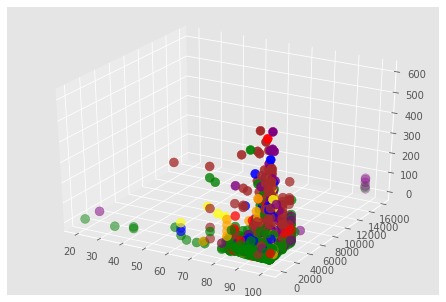

In [38]:
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','yellow','orange','brown','purple']
asignar=[]
for row in datos_y:
    asignar.append(colores[row])

ax.scatter(data_X[:, 0], data_X[:, 1], data_X[:, 2], c=asignar,s=80)

**Interpretación de la gráfica:** observamos la dispersión de las observaciones en los 7 clusters, sin embargo, no podemos observar dicha partición con suficiente claridad. Vemos que el cluster de color green es el más frecuentado que hace referencia a la categoría número 2 de nuestra variable objetivo: Curio, tal y como veíamos numéricamente.

# Aplicación de la técnica: *K*-Means
---

Se trata de una representación gráfica con clusters diferenciados en 3D que nos permita una agrupación de las observaciones en función de la subcategoría del lote. Esta técnica es una de las aplicaciones más habituales dentro de los modelos de aprendizaje no supervisados.

El algoritmo *K-Means* divide un conjunto de $N$ muestras en $K$ subconjuntos, cada uno de ellos descrito por la media $\mu_{j}$ de las muestras del grupo. Los puntos medio de cada grupo se denominan **centroides** (que pueden no ser puntos de $X$). El agloritmo *K-Means* tiene como objetivo **elegir centroides que minimicen la inercia**, o el **criterio de suma de cuadrados dentro del clúster**:

**$$\sum_{i=0}^{n} min_{u_{j} \in K_{j}} (|x_{i} - u_{j}|^{2})$$**

Lógicamente, cuanto menor sea esta distancia media considerando todas las instancias, mejor será el modelo. La regla del codo se utiliza para encontrar el número óptimo de clústers. A medida que aumenta el número de clusters, la suma de la distancia entre cada instancia y el centroide del clúster asociado es más pequeña por lo que la estrategia es tomar el número de clústers que supone un descenso significativo con respecto al número anterior de clústers y a partir del cual esa métrica tiende a estabilizarse.

Para poder aplicar dicha técnica haremos uso de la siguiente importación:

In [39]:
from sklearn.cluster import KMeans

## Obtención del número óptimo de clústers (*k*)
---

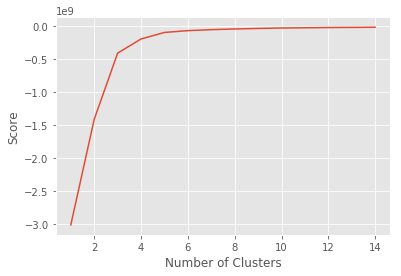

In [40]:
Nc = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(data_X).score(data_X) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

Atendiendo a la gráfica parece que un buen valor de $k$ sería 3 o 4 pues es para los valores donde la curva tiende a estabilizarse (es decir, el error tiende a estabilizarse). Sin embargo, usaremos $k=7$ como el valor de $k$ pues son el número de categorías de las que disponemos.

## Ejecutamos K-Means
---

### Ejecutamos el algoritmo para 7 clusters y obtenemos las etiquetas y los centroides
---

In [41]:
np.random.seed(666)
kmeans = KMeans(n_clusters=7, init="random").fit(data_X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  98.1254386   891.02192982   58.09921409]
 [  96.76714286  117.35        311.53301967]
 [  98.76804124 4290.73195876   64.34633991]
 [  98.17704918 1865.81420765   71.76763476]
 [  98.83306233  522.02439024   59.75790491]
 [  97.90552147  266.7607362    39.77045369]
 [  96.68803828   71.21120984   44.83478179]]


### Predicciones
---

In [42]:
predict = kmeans.predict(data_X)
predict

array([5, 6, 6, ..., 2, 6, 6])

### Obtención de los centroides y representación gráfica
---

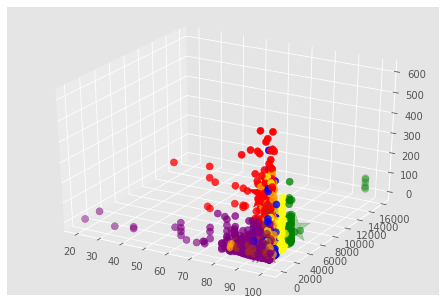

In [43]:
C = kmeans.cluster_centers_
colores1 = ['blue','red','green','yellow','orange','brown','purple']
asignar1 = []
for row in predict:
    asignar1.append(colores1[row])

    
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.scatter(data_X[:, 0], data_X[:, 1], data_X[:, 2], c = asignar1, s = 50)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker = '*', c = colores1, s = 1000) # centroides

Observamos así la división en 7 clusters de nuestras observaciones junto a su centroide.

### Frecuencia de cada uno de los clusters
---

In [44]:
copy =  pd.DataFrame()
copy['categoria']=new_data['category_l1'].values
copy['predict'] = predict;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores1
cantidadGrupo['cantidad']=copy.groupby('predict').size()
cantidadGrupo

,color,cantidad
0,blue,228
1,red,140
2,green,97
3,yellow,183
4,orange,369
5,brown,810
6,purple,1468


Y podemos ver la diversidad de categorias en cada uno de los cluster. Por ejemplo en el grupo 6 (purple).

In [45]:
cluster_purple = copy[copy['predict'] == 6]
cluster_purple.groupby('categoria').size()

categoria
Antiques                137
Clocks                   50
Curio                   884
Interior & Lifestyle     37
Lighters & Pens          98
Rugs & Carpets          144
Silver & Gold           118
dtype: int64

**Interpretación:** de un total de 1959 individuos cuya categoría es "Curio", 884 se encuentran en el cluster 6 (purple).

### Haremos 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D para que nos ayude a visualizar  los grupos y su clasificación:
---

* *supplier_score* frente a *supplier_votes*

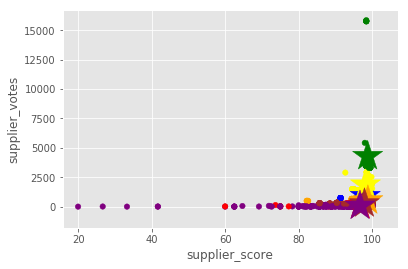

In [46]:
f1 = data['supplier_score'].values
f2 = data['supplier_votes'].values
 
plt.scatter(f1, f2, c=asignar1, s=30)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores1, s=1000)
plt.xlabel('supplier_score')
plt.ylabel('supplier_votes')
plt.show()

Observamos en esta gráfica de forma más clara la existencia de valores atípicos (fuera de rango en comparación con el resto de valores) en la variable *supplier_votes*.

* *supplier_score* frente a *mean_bids*

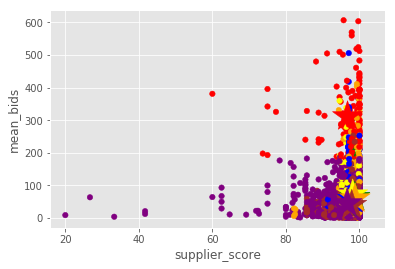

In [47]:
f1 = data['supplier_score'].values
f2 = data['mean_bids'].values
 
plt.scatter(f1, f2, c=asignar1, s=30)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores1, s=1000)
plt.xlabel('supplier_score')
plt.ylabel('mean_bids')
plt.show()

* *supplier_votes* frente a *mean_bids*

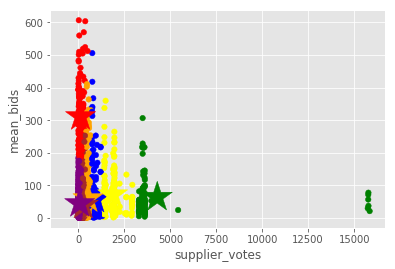

In [48]:
f1 = data['supplier_votes'].values
f2 = data['mean_bids'].values
 
plt.scatter(f1, f2, c=asignar1, s=30)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores1, s=1000)
plt.xlabel('supplier_votes')
plt.ylabel('mean_bids')
plt.show()

## Ejecución de la técnica *K*-Means considerando dos variables explicativas
---

Consideraremos dos variables explicativas *mean_bids* y *supplier_score* y tomaremos un valor de *k* más pequeño (de acuerdo a la gráfica obtenida).

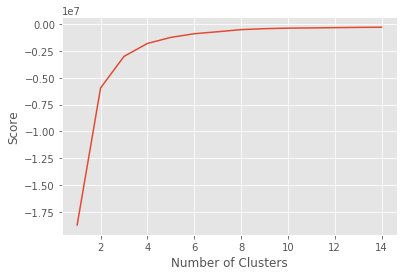

In [49]:
data_X1 = np.array(X[['supplier_score', 'mean_bids']])

Nc = range(1, 15)
kmeans1 = [KMeans(n_clusters=i, init="random") for i in Nc]
kmeans1
score1 = [kmeans1[i].fit(data_X1).score(data_X1) for i in range(len(kmeans1))]
score1
plt.plot(Nc,score1)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

### Ejecución del algoritmo K-Means con $k = 3$
---

In [50]:
np.random.seed(666)
kmeans1 = KMeans(n_clusters=3, init="random").fit(data_X1)
centroids1 = kmeans1.cluster_centers_
predict1 = kmeans1.predict(data_X1)
predict1

array([0, 0, 0, ..., 0, 0, 1])

Text(0, 0.5, 'mean_bids')

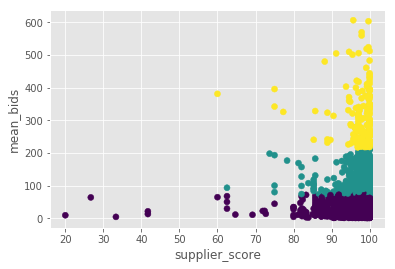

In [51]:
plt.scatter(data_X1[:, 0], data_X1[:, 1], c=predict1) # partición en k=3 clusters
plt.xlabel('supplier_score')
plt.ylabel('mean_bids')

**Conclusión:** vemos como para un valor de k más pequeño podemos observar con mayor claridad la agrupación de las observaciones. Por ejemplo observamos que existe una gran distinción atendiendo a los valores de la variable *mean_bids*: los registros de valores comprendidos entre 1 y 100 pertenecen a un cluster, los registros entre 100 y 200 otro cluster y aquellos registros cuyo valor de puja previa sea superior (más o menos) a 200, constituyen el último cluster.

# Implementación y ejecución de K-Means usando K-Means-Optimizer
---
Implementamos ahora una alternativa a la ejecución k-Means realizada anteriormente. Se trata del k-Means-Optimizer: consideraremos las funciones creadas durante la clase de IPPPD y, una vez que tengamos dicha implementación, crearemos el objeto con nuestros datos y efectuaremos la partición en 7 clusters.

Cabe advertir que no obtendremos una visualización óptima pero es una manera de aplicar una de las técnicas vista en clase a nuestra matriz de datos.

Usaremos las siguientes librerias y funciones:

In [52]:
from linear_models import *
from scipy.spatial.distance import euclidean
from scipy.spatial import distance

In [53]:
def calculate_distances(X, distance, *centroids):
    K = len(centroids)
    distances = np.zeros(shape=(X.shape[0], K))
    #calculamos las distancias de cada instancia a los centros
    for i in range(K):
        for j in range(X.shape[0]):
            distances[j,i] = distance(X[j], centroids[i])
            
    return distances

class KMeansOptimizer:
    
    def __init__(self, K, distance, save_hist_labels=False, initial_centroids=None):
        self.K = K
        self.distance = distance
        self.save_hist_labels = save_hist_labels
        self.hist_labels = []
        self.initial_centroids = initial_centroids
        
        
    def optimize(self, X, Y, J, H):
    
        params_history = []
        
        # centros iniciales
        if self.initial_centroids == None:
            idx = np.random.randint(X.shape[0], size=self.K)
            centroids = X[idx,:]
        else:
            centroids = self.initial_centroids
        
        # Obtengo la asignación de clusters
        labels = H(X, *centroids)
        
        if self.save_hist_labels:
            self.hist_labels.append(labels)
        
        # calculamos el error total (la suma de las distancias)
        error = J(X, labels, *centroids)
        
        
        item = {'c%d'%i:np.array(centroids[i]) for i in range(self.K)}
        item['J'] = error
        params_history.append(item)

        # variable para controlar cuando parar (no se encuentra más mejora)
        stop = False
        
        while not stop:
            
            # calculamos los nuevos centros
            for i in range(self.K):
                centroids[i] = X[labels == i].mean(axis=0)
                
            # Obtengo la nueva asignación de clusters
            labels = H(X, *centroids)
            
            if self.save_hist_labels:
                self.hist_labels.append(labels)

            # calculamos el nuevo error
            new_error = J(X, labels, *centroids)

            if new_error < error:
                item = {'c%d'%i:np.array(centroids[i]) for i in range(self.K)}
                item['J'] = new_error
                params_history.append(item)
                
                print(new_error)
                
            # paramos en caso de no mejorar
            stop = new_error == error
            
            # actualizamos el error
            error = new_error
            
        return pd.DataFrame(data=params_history), centroids
            

class KMeans1(BaseEstimator):
    
    def __init__(self, optimizer):
        super(KMeans1, self).__init__(optimizer)

        self.optimizer = optimizer
    
    def _H(self, X, *params):
        if self.optimizer.K != len(params):
            print(params)
            raise ValueError("El número de parámetros (%d) no se corresponde con el número de atributos (%d) " %
                               (len(params), X.shape[1]))
        
        
        distances = calculate_distances(X, self.optimizer.distance, *params)
            
        #asignamos el cluster más cercano a cada instancia
        return np.argmin(distances[:,:self.optimizer.K], axis=1)
        

    def _J(self, X, Y, *params):
        error = 0
        
        for i in range(self.optimizer.K):
            error += np.array(list(map(lambda x: self.optimizer.distance(x, params[i]), X[Y==i]))).sum()
            
        return error
    

**Una vez tenemos la implementación, creamos el objeto indicando que queremos encontrar 7 clusters y lo entrenamos:**

In [54]:
kmeans_optimizer = KMeans1(KMeansOptimizer(7, euclidean))
kmeans_optimizer.fit(data_X)
kmeans_optimizer._params_history

552122.904821065
527284.2840748949
511003.1210886919
488152.37341670913
483412.5491096914
443389.5686710774
437342.641009499
434725.82501830853
435560.77184891934
429215.4075563531
425201.9391631274
421911.67385187274
419506.1618275185
417507.91200006095
415078.6994388583
413868.5006695237
413012.65284159366
412613.3411024837
412542.81995967426


,J,c0,c1,c2,c3,c4,c5,c6
0,608191.606618,"[99.8, 1960.0, 100.0]","[98.3, 421.0, 19.9375]","[100.0, 118.0, 47.5]","[85.7, 7.0, 182.71428571428572]","[97.5, 90.0, 27.636363636363637]","[83.9, 68.0, 107.5]","[98.7, 171.0, 191.57142857142858]"
1,552122.904821,"[98.37113402061851, 2650.3745704467356, 69.619...","[98.17666666666669, 531.0645161290323, 47.8568...","[97.80106809078772, 179.88785046728972, 36.079...","[95.78938053097345, 30.47787610619469, 258.367...","[96.572601010101, 54.33080808080808, 23.406457...","[96.14545454545451, 43.843636363636364, 90.767...","[98.28206896551727, 227.79310344827587, 219.37..."
2,527284.284075,"[99.02883720930222, 3089.381395348837, 65.1733...","[98.31367403314925, 707.0193370165746, 54.6056...","[97.65459081836318, 219.83532934131736, 34.945...","[95.8515789473684, 41.37894736842105, 299.7999...","[96.59714640198509, 55.178660049627794, 24.601...","[96.46246334310847, 47.81818181818182, 94.6162...","[98.275, 271.08035714285717, 242.47466560012052]"
3,511003.121089,"[99.03170731707307, 3149.6780487804876, 65.461...","[98.23829787234041, 816.3156028368794, 56.6576...","[97.86935960591126, 260.9970443349754, 35.2949...","[96.31428571428569, 48.05952380952381, 321.542...","[96.71731374606506, 64.31164742917103, 25.4265...","[96.2170329670329, 54.30769230769231, 101.4057...","[98.66909090909091, 321.4, 244.92274362465193]"
4,488152.373417,"[98.85428571428567, 3710.442857142857, 55.7801...","[98.29979838709684, 1046.1512096774193, 61.644...","[97.979303482587, 301.25572139303483, 34.81276...","[96.38089887640449, 60.73033707865169, 328.851...","[96.77578558225507, 73.05175600739372, 26.5998...","[96.3122282608695, 59.8125, 104.80500574111247]","[99.01043478260868, 381.504347826087, 228.7346..."
5,483412.549110,"[98.71196581196577, 4040.017094017094, 61.8314...","[98.16368286445018, 1247.5626598465474, 60.226...","[97.95474137931024, 328.1368534482759, 33.8188...","[96.57938144329896, 78.20618556701031, 333.125...","[96.91633333333326, 82.54833333333333, 27.4512...","[96.41590296495951, 61.57142857142857, 107.094...","[99.01832460732986, 507.6910994764398, 152.564..."
6,443389.568671,"[98.68918918918918, 4118.0, 62.44866501459328]","[98.42066420664204, 1492.9963099630995, 61.996...","[97.87590027700811, 300.1565096952909, 37.6875...","[96.85982142857141, 110.50892857142857, 334.35...","[96.94083728278031, 89.74012638230647, 27.8361...","[96.52578947368416, 59.40526315789474, 108.271...","[98.46605080831407, 610.7875288683603, 72.7901..."
7,437342.641009,"[98.68918918918918, 4118.0, 62.44866501459328]","[98.26372549019604, 1670.9264705882354, 67.256...","[97.89167733674755, 296.73879641485274, 41.592...","[97.00862068965516, 127.39655172413794, 336.32...","[96.97419354838702, 88.20099255583126, 27.7333...","[96.32784810126577, 51.9873417721519, 104.5627...","[98.50918580375787, 667.5949895615867, 61.1932..."
8,434725.825018,"[98.68918918918918, 4118.0, 62.44866501459328]","[98.17499999999993, 1745.338888888889, 74.0411...","[97.95486618004851, 304.4683698296837, 44.3528...","[96.96724137931034, 135.3706896551724, 336.330...","[96.95641240569984, 89.56580050293378, 27.9255...","[96.4114634146341, 47.59024390243903, 102.3859...","[98.47321814254865, 708.0928725701943, 54.5748..."
9,435560.771849,"[98.76804123711338, 4290.731958762886, 64.3463...","[98.1770491803278, 1865.8142076502731, 71.7676...","[98.01353558926478, 341.9661610268378, 45.0237...","[96.8225806451613, 135.25, 327.98037127135285]","[97.34721706864563, 113.43135435992579, 30.587...","[96.03528428093638, 32.88963210702341, 72.6439...","[98.50279329608928, 787.7597765363129, 59.3554..."


### Predicciones
---

In [55]:
predict_optimizer = kmeans_optimizer.predict(data_X)
predict_optimizer

array([4, 5, 5, ..., 0, 5, 5], dtype=int64)

### Represetación gráfica
---

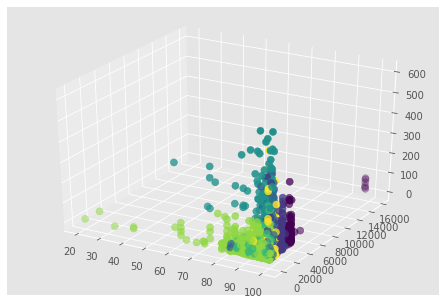

In [56]:
fig2 = plt.figure()
ax = Axes3D(fig2)
ax.scatter(data_X[:, 0], data_X[:, 1], data_X[:, 2], c = predict_optimizer, s=50)

# Análisis de los valores atípicos
---

Atendiendo a las gráficas obtenidas podemos observar casos realmente poco frecuentes, dichos casos constituyen valores atípicos y deberíamos eliminarlos al entrenar nuestro modelo para que no distorsionen los resultados. Para llevar a cabo la visualización de dichos valores poco frecuentes (también llamados marginales) haremos uso del modulo **seaborn**, una técnica de visualización muy frecuente en el análisis de datos.

In [57]:
import seaborn as sns

## Gráfico de cajas de la variable *supplier_votes*
---

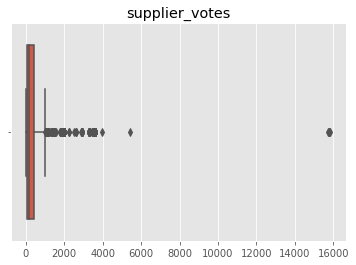

In [58]:
sns.boxplot(list(data['supplier_votes']))
plt.title('supplier_votes')
plt.show()

**Interpretación:** claramente se observa la existencia de valores atípicos (habiendo casos que alcanzan el valor de casi 16000).

## Gráfico de cajas de la variable *supplier_score*
---

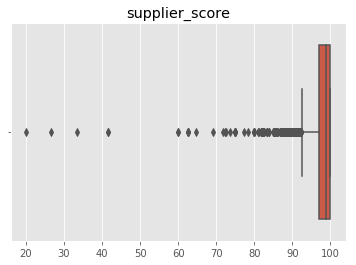

In [59]:
sns.boxplot(list(data['supplier_score']))
plt.title('supplier_score')
plt.show()

## Gráfico de cajas de la variable *mean_bids*
---

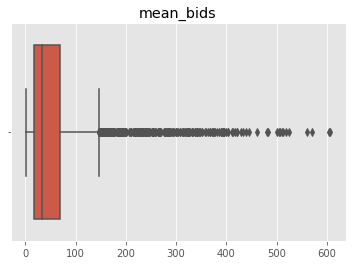

In [60]:
sns.boxplot(list(data['mean_bids']))
plt.title('mean_bids')
plt.show()

## Gráfico de cajas de la variable *supplier_country*
---

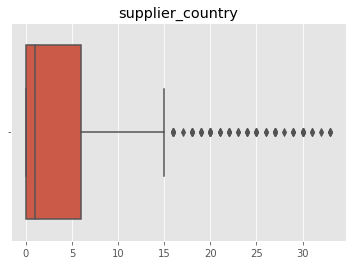

In [61]:
sns.boxplot(list(data['supplier_country']))
plt.title('supplier_country')
plt.show()

## Eliminación de las observaciones atípicas
---

Para la eliminación de valores atípicos no existe una regla exacta; i.e, debes fijar un umbral que te sirva para identificar que valores pueden considerarse atípicos y cuales no. Una manera de estudiar (y eliminar) dichos valores outliers es la siguiente:

* Para cada columna, primero calculamos el valor Z-score para cada valor en la columna (en relación con la media y la desviación estándar de la misma).
* En segundo lugar, tomamos el valor absoluto de dicho valor pues sólo nos importa si está por debajo del umbral. La función *all(axis=1)* nos garantiza que para cada registro, todas las columnas cumplen dicha condición.
* Por último, nos quedamos con los registros que cumplen la condición dada.

In [62]:
df2 = new_data[['category_l1','supplier_country', 'supplier_score', 'supplier_votes', 'mean_bids']]

from scipy import stats 
data_final = df2[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data_final

,category_l1,supplier_country,supplier_score,supplier_votes,mean_bids
0,Curio,0,100.0,310.0,30.142857
1,Curio,0,100.0,14.0,16.250000
2,Curio,1,97.0,35.0,20.636364
3,Silver & Gold,1,100.0,5.0,26.526316
4,Antiques,0,98.4,188.0,47.705882
5,Curio,2,100.0,29.0,3.500000
6,Curio,3,100.0,298.0,32.230769
7,Curio,0,100.0,287.0,16.615385
8,Curio,0,97.3,115.0,40.058824
9,Curio,4,100.0,286.0,65.416667


# Definición de nuestros conjuntos de datos para la elaboración de diferentes modelos de clasificación
---

In [63]:
explicativas = data_final[['supplier_country', 'supplier_score', 'supplier_votes', 'mean_bids']]
objetivo = data_final[['category_l1']]

explicativas.shape[0]

3016

In [64]:
objetivo.shape[0] # coinciden en dimensión

3016

**Comentario:** al eliminar los valores atípicos hemos pasado de tener 3295 observaciones a 3016.

## Análisis de la variable objetivo
---

In [65]:
print(data_final.groupby('category_l1').size()) 

category_l1
Antiques                 253
Clocks                    92
Curio                   1857
Interior & Lifestyle      46
Lighters & Pens          160
Rugs & Carpets           337
Silver & Gold            271
dtype: int64


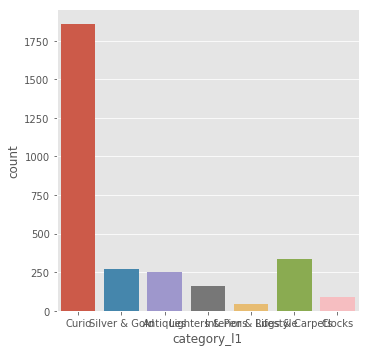

In [66]:
sb.catplot('category_l1', data = data_final, kind="count")

**Conclusión:** tras las modificaciones, contamos con 1857 casos que presetan la subcategoria "Curio" (antes de la eliminación de valores atípicos contabamos con 1959).

# Construcción del conjunto de entrenamiento y el conjunto test
---

* Antes de nada, convertiremos nuestra variable caregórica en numérica con el comando *LabelEncoder()*

In [67]:
from sklearn.preprocessing import LabelEncoder

objetivo_encoder = LabelEncoder().fit(objetivo)
# convertimos la variable objetivo categórica en numérica
# fit: devuelve lo mismo que su argumento se utiliza para hacer más operaciones después

objetivo = objetivo_encoder.transform(objetivo)
objetivo

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 2, 2, ..., 2, 2, 1])

* Partición de nuestros dados en conjunto de entrenamiento y conjunto de aprendizaje:

In [68]:
from sklearn.model_selection import train_test_split

np.random.seed(666)

X_train, X_test, y_train, y_test=train_test_split(explicativas, objetivo, test_size=0.3, random_state = 666, stratify=objetivo)

In [69]:
X_train.shape[0]

2111

In [70]:
X_test.shape[0]

905

# Nomalización de los datos
---
La diferencia de escala entre las características puede dar más importancia a algunas de ellas frente a otras. La normalización de las características unifica la escala, de forma que no influya la relevancia de las características en la clasificación.

In [71]:
from sklearn.preprocessing import StandardScaler
normalizador = StandardScaler().fit(X_train)

normalizador1 = StandardScaler().fit(X_test)

Xn_train = normalizador.transform(X_train)
Xn_test = normalizador1.transform(X_test)

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Javi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Javi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  import sys


* Comprobamos que el conjunto de datos resultante tiene media cero y desviación estándar uno

In [72]:
np.mean(Xn_train)

-8.061344633564377e-16

In [73]:
np.std(Xn_train)

1.0

In [74]:
np.mean(Xn_test)

7.929813957101671e-16

In [75]:
np.std(Xn_test)

1.0

# Algoritmos de clasificación (Aprendizaje Supervisado)
---

## Regresión logística: `LogisticRegression()`
---

In [76]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=666)

### Entrenamiento
---

In [77]:
lr.fit(Xn_train, y_train)

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=666, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Predicciones en el conjunto de entrenamiento
---

In [78]:
predicciones_train = lr.predict(Xn_train)
predicciones_df_train = pd.DataFrame(predicciones_train, columns=['Pred'])
predicciones_df_train.head()

,Pred
0,2
1,2
2,5
3,2
4,2


**Recordatorio:** recordamos que el valor númerico 2 hace referencia a la categoria "Curio".

### Medidas de error de clasificación en el conjunto de aprendizaje
---
* **Porcentaje de acierto en la clasificación**

In [79]:
lr.score(Xn_train, y_train)

0.6342965419232591

### Predicciones en el conjunto test
---

In [80]:
predicciones_test = lr.predict(Xn_test)
predicciones_df_test = pd.DataFrame(predicciones_test, columns=['Pred'])
predicciones_df_test.head()

,Pred
0,2
1,2
2,2
3,2
4,2


O, de manera equivalente:

In [81]:
lr.predict_proba(Xn_test).argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,
       5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2,
       5, 2, 5, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 5, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,

Con este comando se asigna a cada observación la categoría de la variable clase con mayor probabilidad de pertenencia.

* **Probabilidad de pertenencia a cada una de las categorías** (trabajando en el conjunto test)

In [82]:
from sklearn.metrics import log_loss

log_loss(y_test, lr.predict_proba(Xn_test))
lr.predict_proba(Xn_test)

array([[0.06990429, 0.03027776, 0.738506  , ..., 0.04827978, 0.04020473,
        0.06128383],
       [0.07548045, 0.02751182, 0.71253112, ..., 0.03607334, 0.05892365,
        0.08103079],
       [0.0546373 , 0.0118608 , 0.6772942 , ..., 0.04907919, 0.08304697,
        0.10293985],
       ...,
       [0.0469166 , 0.00571593, 0.59630732, ..., 0.07233719, 0.10347076,
        0.13754243],
       [0.06031946, 0.02509165, 0.76712537, ..., 0.04920626, 0.02867289,
        0.05863003],
       [0.04942088, 0.00844299, 0.69716955, ..., 0.05711638, 0.0569327 ,
        0.11253351]])

### Evaluación del rendimiento del modelo en el conjunto test
---

* **Porcentaje de acierto en la predicción**

In [83]:
lr.score(Xn_test, y_test)

0.6353591160220995

**Comentario:** observamos como el porcentaje de acierto es mayor en el conjunto test que en el conjunto de entrenamiento. Lo más común es que sea al revés pues trabajamos sobre el conjunto de aprendizaje y validamos sobre el test, obteniendo un error mas grande. Sin embargo, el resultado obtenido nos dice que el modelo se ajusta mejor en el conjunto test que en el conjunto de aprendizaje obteniendo un mayor porcentaje de acierto en el test.

* **Medida de precisión del modelo** (fracciones de las predicciones correctas, tasa de clasificación correcta))

Hace referencia al porcentaje de acierto en la predicción (lo que acabamos de calcular), dando así una nueva herramienta para obtener dicho porcentaje (o medidad de bondad de ajuste).

In [84]:
from sklearn.metrics import accuracy_score

y_true = y_test
y_predict_lr = lr.predict(Xn_test)

accuracy_score(y_true, y_predict_lr) # vemos que coincide con lo anterior

0.6353591160220995

### Clasificación para un nuevo individuo
---

Nuevo individuo:
    
- *supplier_country* = 22
- *supplier_score* = 97 (puntuación recibida)
- *supplier_votes* = 36 (votos obtenidos)
- *mean_bids* = 25 (media de las pujas previas del producto)

In [85]:
lr.predict([[22, 97, 36, 25]])

array([6])

**Conclusión:** nuestro clasificador nos dice que el producto pertenece a la subcategoría "Silver & Gold" (6).

### Tabla de confusión
---
Herramienta que nos permite observar cuantos individuos han sido clasificados de manera correcta y cuántos han sido clasificados erroneamente en cada una de las categorías de la variable respuesta.

In [86]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_predict_lr)

array([[  0,   0,  66,   0,   0,  10,   0],
       [  0,   0,  22,   0,   0,   5,   1],
       [  0,   0, 542,   0,   0,  15,   0],
       [  0,   0,  11,   0,   0,   3,   0],
       [  0,   0,  39,   0,   0,   9,   0],
       [  0,   0,  68,   0,   0,  33,   0],
       [  0,   0,  64,   0,   0,  17,   0]], dtype=int64)

**Interpretación**

1. Observamos que 66 individuos que en el conjunto test presentan la categoria 0, nuestro clasificador lo selecciona en la categoría 2 (Curio), es decir, son 66 individuos clasificados erroneamente (hay más, evidentemente).
2. 542 indiviudos que presentan la categoría Curio (número 2) son clasificados en dicha categoría por regresión logística, i.e, son individuos clasificados de manera correcta.

#### Número de casos (individuos) seleccionados de manera correcta

In [87]:
elem_correctos_lr = [confusion_matrix(y_true, y_predict_lr)[i,i] 
                      for i in range(confusion_matrix(y_true, y_predict_lr).shape[0])]

sum(elem_correctos_lr)

575

O, equivalentemente:

In [88]:
accuracy_score(y_true, y_predict_lr, normalize=False) 

575

**Conclusión:** de un total de 905 individuos, el algoritmo clasifica correctamente 575.

### Resumen de clasificación con nuestro conjunto test
---

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict_lr))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.00      0.00      0.00        28
           2       0.67      0.97      0.79       557
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        48
           5       0.36      0.33      0.34       101
           6       0.00      0.00      0.00        81

   micro avg       0.64      0.64      0.64       905
   macro avg       0.15      0.19      0.16       905
weighted avg       0.45      0.64      0.53       905



C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Interpretación de los resultados**

En nuestro caso vemos que se utilizaron como “soporte” 76 registros Antiques, 28 de Clocks, 557 de Curio, 14 de Interior & Lifestyle, 48 de Lighters & Pens, etc. (total de 905 registros). 

Podemos ver la precisión con que se acertaron cada una de las categorias:
* Vemos por ejemplo que ha habido 542 aciertos y 15 fallos en la categoría Curio (0.97 recall). 
* La valoración que de aqui nos conviene tener en cuenta es la de F1-score, que tiene en cuenta la precisión y recall. El promedio de F1 es de 64% lo cual no está mal (mismo resultado que *accuracy_score(y_true, y_predict_lr)*)


## Regresión Logística con `cross-validation`
---

In [90]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

En el algoritmo anterior hemos creado un modelo de Regresión Logística usando como técnica de validación la simple; dividiendo el conjunto de datos en entrenamiento y test, entrenando el modelo en el conjunto de aprendizaje y validando en el conjunto test. Esta técnica se conoce con el nómbre de **Método H (holdout)**. A continuación cambiamos nuestra técnica de validación, dividiremos nuestro conjunto de entrenamiento en *k* pliegues y efectuaremos la técnica conocida de Cross-Validation.

Debemos determinar el número de pliegues. Seleccionaremos 6 pliegues del conjunto de entrenamiento de manera que en cada uno de los pliegues se tomará como conjunto test y el resto de los pliegues formarán el conjunto de entrenamiento. Así, entrenaremos el algoritmo en el conjunto de entrenamiento y validaremos en el conjunto test (en el pliegue en cuestión). Obtendremos de esta manera un porcentaje de acierto y calcularemos el valor medio de $\%$ de acierto, obteniendo así una medida de bondad de ajuste del modelo.

In [91]:
kfold6 = StratifiedKFold(6)

list(kfold6.split(explicativas, objetivo))[1] 
# indices de las observaciones tomadas para entrenamiento y test en el primer pliegue

(array([   0,    1,    2, ..., 3013, 3014, 3015]),
 array([ 432,  433,  435,  462,  463,  480,  485,  486,  487,  488,  489,
         490,  492,  493,  497,  498,  499,  500,  501,  502,  504,  505,
         506,  507,  508,  509,  510,  512,  513,  514,  515,  516,  517,
         518,  520,  521,  522,  523,  524,  527,  528,  529,  531,  532,
         533,  535,  537,  538,  539,  540,  541,  542,  544,  546,  547,
         548,  549,  550,  551,  552,  553,  555,  556,  557,  558,  559,
         561,  563,  564,  565,  566,  567,  568,  569,  570,  571,  573,
         574,  575,  576,  577,  579,  580,  581,  582,  583,  584,  585,
         586,  587,  588,  589,  590,  591,  592,  593,  594,  595,  596,
         597,  599,  601,  602,  603,  604,  605,  607,  608,  609,  610,
         611,  612,  613,  614,  615,  616,  617,  618,  619,  620,  621,
         622,  623,  624,  625,  626,  627,  628,  629,  630,  631,  632,
         633,  635,  636,  637,  638,  639,  640,  641,  642,

### Entrenamos el algoritmo y obtenemos el porcentaje de bondad de ajuste en cada pliegue
---

In [92]:
estimator = LogisticRegression(random_state=666, fit_intercept=False)

scores = cross_val_score(estimator, Xn_train, y_train, 
                         cv=kfold6.split(Xn_train, y_train), scoring="accuracy")

scores # cuanto más alto, mejor ajuste de los datos

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

array([0.50704225, 0.52957746, 0.55807365, 0.55397727, 0.56321839,
       0.54597701])

### Medidas de error de clasificación
---

* **Desviación estándar**

In [93]:
scores.std()

0.01931528966989634

* **Porcentaje de acierto medio** 

In [94]:
scores.mean()

0.5429776746211529

### Evaluación del rendimiento del modelo
---

In [95]:
print("Acuracidad del modelo: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Acuracidad del modelo: 0.54 (+/- 0.04)


**Conclusión:** menor porcentaje de acierto que realizando la regresión logística. Con este resultado llegamos a que aplicar *cross-validation* en el conjunto de entrenamiento como técnica de evaluación de un modelo de regresión logística no mejora la precisión (medida de acuracidad) alcanzada por el modelo de regresión logística usando la validación simple como técnica de evaluación.

## Árboles de clasificación: `DecisionTreeClassifier()`
----

### Definición y entrenamiento de nuestro modelo

In [96]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=666)

classifier = classifier.fit(Xn_train, y_train)
classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best')

### Predicciones en el conjunto test
---

In [97]:
predicciones_arbol = classifier.predict(Xn_test)
predicciones_arbol

array([2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 4, 2, 2, 2, 3, 5, 2, 2, 2, 2,
       2, 6, 0, 4, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
       2, 2, 6, 4, 2, 0, 2, 2, 0, 2, 2, 4, 2, 2, 4, 3, 2, 2, 5, 2, 2, 2,
       5, 0, 2, 2, 0, 2, 6, 2, 6, 2, 2, 4, 6, 2, 2, 2, 4, 2, 2, 5, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 5, 5, 2, 2, 4, 2, 2, 2, 2, 2, 5,
       6, 2, 2, 2, 1, 2, 2, 2, 2, 6, 2, 5, 2, 6, 2, 2, 0, 0, 2, 2, 2, 6,
       2, 2, 2, 0, 2, 2, 5, 2, 2, 6, 2, 4, 2, 2, 2, 2, 2, 4, 0, 0, 5, 2,
       2, 2, 4, 5, 2, 5, 5, 2, 2, 2, 2, 4, 2, 6, 1, 2, 5, 2, 5, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 6, 2, 2, 4, 2, 2, 2, 2, 6, 1, 2, 2, 2, 2, 0,
       2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 0, 2, 5, 2, 2, 2, 1, 2, 2, 5, 2,
       2, 2, 5, 0, 2, 2, 6, 2, 5, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 5,
       2, 1, 2, 0, 2, 0, 4, 2, 0, 0, 1, 6, 2, 0, 5, 6, 5, 2, 2, 5, 2, 5,
       0, 2, 0, 2, 2, 2, 6, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 4, 2, 2, 2, 6,
       5, 5, 2, 2, 5, 2, 0, 2, 4, 5, 6, 2, 2, 2, 6,

### Tabla de confusión

Como hemos visto en el análisis logístico, la tabla de confusión se trata de una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Así pues, podremos determinar el número total de observaciones que son predichas de manera correcta de manera que, a mayor número de observaciones predichas correctamente, mejor se ajustará nuestro algoritmo a los datos del problema.

In [98]:
confusion_matrix(y_test, predicciones_arbol)

array([[  4,   1,  48,   1,   6,   4,  12],
       [  3,   4,  15,   0,   2,   3,   1],
       [ 42,  16, 388,   2,  31,  34,  44],
       [  3,   1,   2,   2,   2,   3,   1],
       [  8,   0,  27,   2,   5,   3,   3],
       [ 16,   3,  33,   1,   2,  41,   5],
       [  9,   1,  36,   0,   6,   9,  20]], dtype=int64)

In [99]:
elem_correctos_arbol = [confusion_matrix(y_test, predicciones_arbol)[i,i] 
                      for i in range(confusion_matrix(y_test, predicciones_arbol).shape[0])]

sum(elem_correctos_arbol)

464

**Comentario:** atendiendo al resultado obtenido vemos que el número de observaciones seleccionadas correctamente, es decir, el número de observaciones tales que el valor observado (subcategoría) y el predicho coinciden es inferior al obtenido en el algoritmo logístico anterior (575 observaciones clasificadas correctamente). Así pues, veremos como el porcentaje de acierto es inferior en este modelo que en el anterior.

### Evaluación del modelo
---
De manera análoga a lo realizado en el modelo Logístico, una forma de conocer cómo de bueno es nuestro modelo es observar la fracción de predicciones correctas realizadas por el mismo. Dicho resultado, que nos proporciona una forma para determinar la bondad de ajuste de nuestro modelo, podemos obtenerlo mediante dos formas:
1. recurriendo a la función *accuracy_score* del módulo *sklearn.metrics* obteniendo así la acuracidad obtenida (bondad de ajuste, precisión del modelo) aplicando el módelo de árboles de clasificación.
2. usando el objeto creado por el algoritmo de árboles de clasificacióny aplicarle la función *score()* para así determinar con qué frecuencia el clasificador es correcto.

In [100]:
accuracy_score(y_test, predicciones_arbol)

0.512707182320442

O, de manera equivalente:

In [101]:
classifier.score(Xn_test, y_test)

0.512707182320442

**Conclusión:** a partir del resultado obtenido vemos que nuestro algoritmo no es muy fiable pues el porcentaje de acierto en el conjunto test es del $51.27\%$. A continuación veremos otro algoritmo de aprendizaje automático conocido como **Random Forest** que va a obtener una medida de bondad de ajuste mejor que la obtenida en el modelo de árboles de clasificación y que se basa en la construcción de una gran cantidad de éstos. Con este nuevo algoritmo obtendremos una mejora en el resultado predictivo, sin embargo, al contar con una gran cantidad de árboles, la interpretación alcanzada será peor que si contaramos con un único árbol de clasificación.

## Random Forest: `RandomForestClassifier()`
---
Random Forest es un algoritmo predictivo que usa la técnica de *bagging* para combinar diferentes arboles, donde cada árbol es construido con observaciones y variables aleatorias.

En forma resumida sigue este proceso:

1. Selecciona individuos al azar (usando muestreo con reemplazo) para crear diferentes set de datos.
2. Crea un árbol de decisión con cada set de datos, obteniendo diferentes arboles, ya que cada set contiene diferentes individuos y diferentes variables en cada nodo.
3. Al crear los arboles se eligen variables al azar en cada nodo del arbol, dejando crecer el arbol en profundidad (es decir, sin podar).
4. Predice los nuevos datos usando el "voto mayoritario", es decir, la clase más frecuente (o común) a lo largo de los diferentes árboles.

En cuanto a la técnica de evaluación del modelo creado a lo largo de este trabajo llevaremos a cabo tres modelos RandomForest obteniendo una medida de acuracidad media distinta en cada caso:

- Random Forest usando la técnica de evaluación de cross-validation sobre el conjunto de aprendizaje
- Random Forest usando el proceso Grid Search para optimizar los parámetros del modelo tomados
- Random Forest usando la técnica de evaluación simple (método H (holdout) o training-test)

## RF: Validación cruzada
---

In [102]:
from sklearn.ensemble import RandomForestClassifier

### Entrenamos el algoritmo y obtenemos el porcentaje de ajuste en cada árbol (pliegue)
---

In [103]:
estimador_rf = RandomForestClassifier(random_state=666, 
                                      max_depth=5, 
                                      criterion='entropy',
                                      min_samples_split=6,
                                      min_samples_leaf=3)

scores_rf = cross_val_score(estimador_rf,
                            Xn_train, y_train, 
                            cv=kfold6.split(Xn_train, y_train), scoring="accuracy")

scores_rf

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

array([0.66478873, 0.65915493, 0.65439093, 0.65625   , 0.68965517,
       0.67528736])

### Porcentaje medio de acierto del modelo
---

In [104]:
scores_rf.mean()

0.6665878542586093

### Medida de acuracidad del modelo (mismo resultado que lo anterior)
---

In [105]:
print("Acuracidad del modelo: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

Acuracidad del modelo: 0.67 (+/- 0.02)


**Conclusión:** se obtiene un mejor ajuste de los datos alcanzando una tasa de clasificación correcta (o de bondad de ajuste) del $67\%$ en relación a la regresión logística donde obteníamos un $63\%$.

## Optimización de parámetros con Grid Search
---
La mayoría de los modelos de Machine Learning cuentan con varios parámetros para ajustar su comportamiento, por lo tanto una alternativa que tenemos para reducir el *sobreajuste* es optimizar estos parámetros por medio de un proceso conocido como **grid search** e intentar encontrar la combinación ideal que nos proporcione mayor precisión. 

Se trata de una búsqueda exhaustiva por el paradigma de fuerza bruta en el que se especifica una lista de valores para diferentes parámetros, y la computadora evalúa el rendimiento del modelo para cada combinación de éstos parámetros para obtener el conjunto óptimo que nos brinda el mayor rendimiento.

A continuación vermos un ejemplo utilizando un el modelo RandomForest con validación cruzada expuesto anteriormente donde el conjunto de parámetros a evaluar son los siguientes: *min_samples_split*, *min_samples_leaf*, *criterion*, *max_depth* y *n_estimators*, indicandonos por ejemplo, *min_samples_split* que si se llega a un subconjunto de tal número de muestras no sigamos dividiendo y *n_estimators* el número de árboles en cada proceso (a medida que aumentemos dicho parámetro aumentará la precisión de la clasificación pero perderemos en interpretación y el tiempo de funcionamiento será mayor, por lo que, en función de como de mayor sea el aumento será aconsejable considerar un número mayor o menor de árboles).

Tomamos la variable predictora que mejor predice la respuesta, buscamos el corte que mejor divida los datos dando lugar a dos subconjuntos de datos. Luego, determinamos el mejor atributo y el mejor corte para dividir cada 
subconjunto de datos.

In [106]:
from sklearn.model_selection import GridSearchCV

### Entrenamos el algoritmo para cada uno de los casos posibles (i.e, todas las combinaciones posibles de los parámetros)
---

In [107]:
params = {
        'min_samples_split': [2,4,8,12],
        'min_samples_leaf': [2,4,6],
        'criterion': ['gini', 'entropy'],
        'max_depth': [5,8,12,24],
        'n_estimators': [10,50,100],
        }

gs = GridSearchCV(estimador_rf, params, refit=True, cv=kfold6.split(Xn_train, y_train), scoring="accuracy")

gs.fit(Xn_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000014EB4696B10>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=666, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 4, 8, 12], 'min_samples_leaf': [2, 4, 6], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 8, 12, 24], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### Bondad de ajuste (fracción de las predicciones correctas) de la mejor combinación de parámetros
---

In [108]:
print("Acuracidad del modelo:", gs.best_score_)

Acuracidad del modelo: 0.6830885836096636


**Conclusión:** aplicar el proceso Grid Search al modelo RandomForest proporciona el mejor ajuste de los datos. Vemos como la precisión en este caso, es decir, la fracción de las predicciones correctas, es superior a la acuracidad obtenida en el modelo RandomForest sin aplicar este proceso de optimización. Este resultado era de preveer pues con este método lo que conseguimos es la mejor combinación de los parámetros que definen un modelo RandomForest.

### ¿Cuál es la mejor combinación de los parámetros que nos proporciona una mayor precisión?
---

In [109]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

Así pues, el modelo RandomForest (usando validación cruzada) que me proporciona un mejor ajuste de datos es el que tiene los siguientes parámetros:

- *min_samples_split*: 2
- *min_samples_leaf*: 2
- *criterion*: 'gini'
- *max_depth*: 12
- *n_estimators*: 100

In [110]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=666, verbose=0, warm_start=False)

### Precisión del modelo (medida de 'acuracidad')
---

In [111]:
print("Acuracidad del modelo: %0.2f (+/- %0.2f)" % (gs.best_score_.mean(), gs.best_score_.std() * 2))

Acuracidad del modelo: 0.68 (+/- 0.00)


**Conclusión:** coincide con el resultado anterior pues hemos tomado el  RandomForest con la elección de los valores de los parámetros con el que se obtiene un mayor porcentaje de acuracidad del modelo. El porcentaje de acuracidad del modelo es del $68\%$.

### Importancia de las variables
---

In [112]:
gs.best_estimator_.feature_importances_

array([0.12427363, 0.18312322, 0.32308666, 0.36951649])

**Comentario:** observamos que la cuarta variable (*mean_bids*) es la variable con mayor influencia en el modelo.

## Random Forest con validación simple
---
A lo largo de nuestro trabajo, hemos empleado algunos algoritmos mediante la función `RandomForestClassifier()`: en primer lugar, construimos el objeto fijando unos valores de los parámetros y, a través de validación cruzada, evaluamos la predicción de dicho modelo, obteniendo una acuracidad media (bondad de ajuste de nuestro modelo) del  67% .

Posteriormente, mediante la función GridSearchCV realizabamos un proceso de optimización de dichos parámetros para así obtener la mejor combinación posibles de ellos. Veíamos como a partir de estos parámetros obteníamos una bondad de ajuste superior a la obtenida en el modelo RandomForest usando validación cruzada como técnica de evaluación del modelo.

Pues bien, a continuación mostramos un modelo de RandomForest pero usaremos la partición en conjuntos test y conjuntos de aprendizaje efectuada por la función *train_test_split* para efectuar la evaluación de nuestro modelo, es lo que se conoce como Método H (holdout) o Training-Test.

### Definición y entrenamiento de nuestro modelo
---
Consideraremos los valores de los parámetros que la función *GridSearch()* proporcionaba como mejor combinación lineal posible para así poder realizar una comparación entre el modelo RandomForest usando validación simple y el modelo RandomForest usando validación cruzada creado anteriormente.

In [113]:
clf=RandomForestClassifier(random_state = 666, 
                           min_samples_split = 2, 
                           min_samples_leaf = 2, 
                           criterion = 'gini', 
                           max_depth = 12, 
                           n_estimators=100)

clf.fit(Xn_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=666, verbose=0, warm_start=False)

### Realizamos las predicciones en el conjunto de prueba
---

In [114]:
y_pred_cf = clf.predict(Xn_test)
y_pred_cf

array([2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 0, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 5,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 6,
       5, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 5, 5, 2, 0, 2, 2, 5, 2, 5,
       2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 5, 2, 2, 2, 2, 2,

### Evaluación del modelo
---
Para el cálculo de la precisión de nuestro modelo importamos el módulo `scikit-learn metrics`.

In [115]:
from sklearn import metrics
print("Accuracidad del modelo:", metrics.accuracy_score(y_test, y_pred_cf))

Accuracidad del modelo: 0.6530386740331492


Otra forma de ver la fracción de predicciones correctas, dicho de otro modo, conocer con qué frecuencia el clasificador es correcto, es recurriendo a la función *score()*:

In [116]:
clf.score(Xn_test, y_test)

0.6530386740331492

### Clasificación de un nuevo individuo
---

In [117]:
clf.predict([[22, 97, 36, 25]])

array([6])

**Comentario:** de manera análoga a la regresión logística, nuestro clasificador nos dice que el producto pertenece a la subcategoría "Silver & Gold" (6).

### Importancia de nuestras variables regresoras en el modelo
---

In [118]:
index_values = ['supplier_country', 'supplier_score', 'supplier_votes', 'mean_bids']
feature_imp = pd.Series(clf.feature_importances_, index=index_values).sort_values(ascending=False)
feature_imp

mean_bids           0.369516
supplier_votes      0.323087
supplier_score      0.183123
supplier_country    0.124274
dtype: float64

 Tal y como observabamos anteriormente, la variable *mean_bids* es la variable más influyente en nuestro modelo.

* **Visualización gráfica**

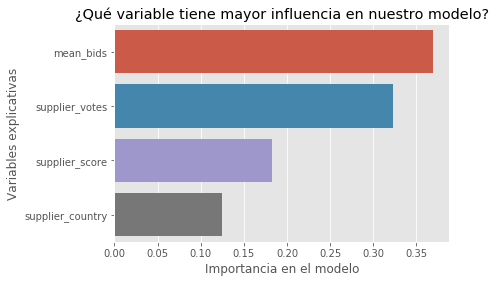

In [119]:
sns.barplot(x = feature_imp, y = feature_imp.index)

plt.xlabel('Importancia en el modelo')
plt.ylabel('Variables explicativas')
plt.title("¿Qué variable tiene mayor influencia en nuestro modelo?")
plt.show()

# Técnica del vecino más cercano: `KNeighborsClassifier()`
---

**Objetivo.** Dado un conjunto de entrenamiento (vectores numéricos con una categoría asignada) y un ejemplo nuevo devolver la categoría mayoritaria en los *k* ejemplos del conjunto de entrenamiento más cercanos al ejemplo que se quiere clasificar.

In [120]:
from sklearn.neighbors import KNeighborsClassifier

## Definición y entrenamiento de nuestro modelo
---

In [121]:
knn = KNeighborsClassifier()

knn.fit(Xn_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

El algoritmo toma $n\_neighbors=5$ como número de vecinos y la distancia de minkowski usada es la de parámetro 2 ($p=2$) $\rightarrow$ distancia euclídea.

### Predicciones
---

In [122]:
knn.predict(Xn_test)

array([2, 2, 2, 2, 2, 2, 5, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 5, 2, 4, 2, 2,
       2, 2, 5, 0, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 5, 2, 0, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 6, 2, 2, 2, 4,
       2, 6, 2, 6, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 4, 2, 2, 5, 2, 2,
       5, 2, 2, 2, 2, 5, 2, 6, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5,
       5, 2, 2, 2, 1, 5, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 6,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 5, 5, 2, 5, 2, 2, 2, 2, 4, 2, 6, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 5, 2, 0, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 2, 2, 2, 0, 2, 1, 2, 5, 5, 5, 0, 2, 2, 0, 2, 5,
       2, 2, 5, 2, 2, 2, 6, 2, 0, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 5, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,

### Evaluación del modelo
---

In [123]:
knn.score(Xn_test, y_test)

0.6198895027624309

**Conclusión:** obtenemos un porcentaje menor que en la regresión logística.

Otra forma de ver la acuracidad del modelo es:

In [124]:
y_true = y_test
y_predict_knn = knn.predict(Xn_test)

accuracy_score(y_true, y_predict_knn)

0.6198895027624309

### Tabla de confusión para el método de kNN
--- 

In [125]:
confusion_matrix(y_true, y_predict_knn)

array([[  8,   1,  58,   0,   2,   6,   1],
       [  2,   1,  19,   0,   0,   6,   0],
       [ 28,   5, 495,   0,   5,  16,   8],
       [  5,   0,   7,   0,   0,   2,   0],
       [  9,   1,  25,   1,   4,   6,   2],
       [  8,   2,  47,   0,   1,  42,   1],
       [  4,   0,  48,   1,   3,  14,  11]], dtype=int64)

**Interpretación de los resultados**

* 8 individuos que estaban clasificados en la categoria 0 ("Antiques") son clasificados por dicho método en dicha categoría. Sin embargo, 58 individuos que presentaban la categoria 0 ("Antiques") son clasificados en la categoría 2 ("Curio"), siendo por tanto clasificados de manera errónea.

* 495 individuos que presentaban la categoría 2 ("Curio") son clasificados por dicho método de manera correcta. Por otro lado, 28 individuos que presentaban dicha categoría, son clasificados, de manera errónea, en la categoría 0 ("Antiques").

**Número de casos (individuos) seleccionados de manera correcta**

In [126]:
elem_correctos_knn = [confusion_matrix(y_true, y_predict_knn)[i,i] 
                      for i in range(confusion_matrix(y_true, y_predict_knn).shape[0])]

sum(elem_correctos_knn)

561

**Conclusión:** 561 elementos son seleccionados por dicho método en la categoría correcta. Obtenemos así un menor número que en el caso de la regresión logística (575 individuos seleccionados correctamente), lo cual tiene sentido pues el porcentaje de aciertor era inferior en el método knn de vecinos más cercanos, es decir, la acuracidad del modelo era más baja.

Una manera equivalente de ver el número de casos clasificados correctamente sería:

In [127]:
accuracy_score(y_true, y_predict_knn, normalize = False)

561

### Clasificación de un nuevo individuo
---

In [128]:
knn.predict([[22, 97, 36, 25]])

array([5])

**Conclusión:** el algoritmo clasifica al individuo en la categoría número 5, es decir, "Rugs & Carpet". Observamos aquí una diferencia con la regresión logística, pues dicho método clasificada a dicho individuo en la categoría número 6 ("Silver & Gold").

## Naive Bayes
---

Otra de las técnicas de clasificación más usual en la construcción de modelos que predicen la probabilidad de pertenencia a cada una de las clases de las que disponemos, y que proporciona buenos resultados, es la técnica Naive Bayes que consiste en lo siguiente:
- Se dispone de un atributo nominal (variable categórica) con *m* posibles valores que indica la clase a que pertenece cada individuo.
- Dichas clases deben ser excluyentes, es decir, un individuo no puede pertenecer simultanemanete a dos clases.
- El problema consista en, conocido el vector de características de un individuo, determinar la clase *c* a que pertenece. Así pues, se calcularan las probabilidades de pertenencia a cada una de las clases $P(c_{i}, X)$ y se clasificará al individuo en la clase que proporciona máxima probabilidad.

### Definición y entrenamiento del modelo
---

In [129]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(Xn_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### Predicciones para los elementos de la muestra test
---

In [130]:
nb_pred = nb.predict(Xn_test)
print(nb_pred)

[2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 6 6 2 2 2 2 2 5 2 2 2 5 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 5 2 2 2 2 5 2 2 2 2 2 5 5 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 5 2 5 2 2 2 2 2 2 2 5 2 5 2 2 2 5 2 2 2 2 2 2 2 5 2
 2 2 2 2 2 5 2 2 6 2 2 2 2 2 2 2 5 2 2 2 6 0 2 2 2 2 6 0 5 2 2 2 2 2 2 2 2
 5 6 2 2 2 2 2 2 2 5 2 2 5 2 6 2 2 2 2 2 2 2 0 5 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 5 2 2 2 2 2 5 2 5 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 5 2
 5 2 2 2 5 2 2 2 2 2 2 2 2 2 6 2 1 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 5 5 2 5
 2 2 5 2 4 2 2 2 2 2 2 5 2 5 2 2 2 2 5 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 5
 2 2 2 2 2 2 2 2 5 2 2 2 5 2 2 2 2 2 2 2 0 2 2 2 6 2 2 2 6 2 2 2 2 2 2 2 2
 2 2 2 2 2 6 2 0 2 2 2 5 2 6 2 6 2 2 2 2 6 2 5 5 5 2 2 5 2 5 2 2 2 5 1 6 2
 2 5 5 2 6 2 2 2 2 2 2 2 5 2 2 2 5 2 2 2 2 5 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2
 2 2 2 2 4 6 2 2 5 5 1 1 2 0 2 2 2 2 0 2 1 5 2 0 4 2 2 2 2 5 2 5 2 2 2 5 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 6 2 2
 2 2 6 2 5 5 5 2 2 2 2 2 

### Evaluación del modelo calculando la tasa de acierto del mismo
---

In [131]:
accuracy = accuracy_score(y_test, nb_pred)
print(accuracy)

0.6077348066298343


**Comentario:** en comparación con el modelo de los vecinos más cercanos, observamos que la técnica de clasificación Naive Bayes proporciona una fracción de predicciones correctas inferior.

### Probabilidades de pertenencia a cada clase
---

In [132]:
prob = nb.predict_proba(Xn_test)
print(prob[1:10,])

[[4.51955526e-02 1.84458968e-02 8.34608760e-01 4.81570785e-03
  1.16085105e-02 2.67445890e-02 5.85809837e-02]
 [3.27955561e-02 4.72007343e-03 7.42552326e-01 1.43049205e-02
  8.09098994e-02 4.05586050e-02 8.41586199e-02]
 [1.66791087e-01 4.62442172e-02 3.27703473e-01 8.67082047e-03
  1.85988860e-01 1.08169157e-01 1.56432386e-01]
 [3.31097606e-02 1.41081196e-02 8.21618347e-01 4.59267753e-03
  6.95161855e-02 1.55171774e-02 4.15377321e-02]
 [4.41579961e-02 1.86962568e-02 7.67747893e-01 6.24812751e-03
  9.05277560e-02 2.08569925e-02 5.17649785e-02]
 [2.59770200e-01 4.85810913e-02 2.51962885e-02 3.19715532e-03
  8.07357783e-13 5.49562535e-01 1.13692730e-01]
 [3.61672558e-02 1.33859922e-02 8.42946603e-01 4.83108250e-03
  3.95260299e-02 1.88423597e-02 4.43006771e-02]
 [4.72157620e-02 1.98428058e-02 7.67536419e-01 6.44066850e-03
  8.51058833e-02 2.12751461e-02 5.25833152e-02]
 [7.36851506e-02 2.87911980e-02 6.41938724e-01 7.82901219e-03
  1.25085642e-01 4.18850158e-02 8.07852572e-02]]


Atendiendo a dichas probabilidades vemos que, efectivamente, el modelo clasifica a cada observación del test en la clase en la que su probabilidad de pertenencia es máxima.

### Matriz de confusión
---

In [133]:
tab_conf = confusion_matrix(y_test, nb_pred)
print(tab_conf)

[[  1   0  61   0   0   9   5]
 [  2   1  20   0   0   4   1]
 [  6   9 505   0   1  26  10]
 [  0   0  11   0   0   3   0]
 [  3   0  35   0   0   8   2]
 [  3   4  50   0   2  37   5]
 [  3   0  51   0   0  21   6]]


Otra forma de ver el número de casos del conjunto test clasificados de manera correcta es haciendo uso de la función *dig()* de numpy:

In [134]:
sum(np.diag(tab_conf)) 

550

**Comentario:** como ya veíamos al calcular la tasa de acierto del clasificador, el número de predicciones correctas es inferior al que se obtiene en la técnica K-Nearest Neighbors (561 observaciones del conjunto test clasificados de manera correcta).

## Resumen
---
Atendiendo a la medida de bondad de ajuste de cada uno de ellos, o equivalentemente, el porcentaje de acierto en la clasificación 
($100*\text{fracciones de predicciones correctas}$) creamos la siguiente tabla a modo resumen para visualizar los resultados obtenidos:

In [135]:
resumen = pd.DataFrame({'Regresión Logística': [accuracy_score(y_true, y_predict_lr)], 
                       'Regresión Logística CV': [scores.mean()],
                       'Árboles de clasificación': [classifier.score(Xn_test, y_test)],
                       'Random Forest CV': [scores_rf.mean()], 
                       'Random Forest Grid Search': [gs.best_score_],
                       'Random Forest' : [metrics.accuracy_score(y_test, y_pred_cf)],
                       'K-Nearest Neighbors': [accuracy_score(y_true, y_predict_knn)],
                       'Naive Bayes': [accuracy_score(y_test, nb_pred)]})
resumen

,Regresión Logística,Regresión Logística CV,Árboles de clasificación,Random Forest CV,Random Forest Grid Search,Random Forest,K-Nearest Neighbors,Naive Bayes
0,0.635359,0.542978,0.512707,0.666588,0.683089,0.653039,0.61989,0.607735


### Conclusiones
---
De acuerdo al resumen obtenido el modelo que mejor se ajusta a los datos es el algoritmo del **Random Forest Grid Search** obteniendo una fracción de clasificaciones correctas del $0.683089$, o lo que es lo mismo, un $68.23\%$ de acierto en la clasificación en el conjunto de datos de validación (test). Por contra, los peores modelos que se ajusta a los datos son el modelo de **Regresión Logística CV**, es decir, el modelo de regresión logística que fragmenta el conjunto de entrenamiento en pliegues considerando el resto de pliegues como muestra de aprendizaje y validando en el pliegue seleccionado, es decir, usando cross-validation como técnica de validación y el algoritmo de los **Árboles de clasificación**; técnica que nos permite una fácil interpretación pudiendo incluso visualizar la construcción del respectivo árbol pero que adquiere un bajo porcentaje de acierto en la predicción. Ambos modelos alcanzan un porcentaje de acierto de clasificación del $54.3\%$ (la media del porcentaje efectuado en cada pliegue) y $51.27\%$ respectivamente.

Otro aspecto a considerar es que el modelo **Random Forest** obtiene una mejor precisión usando la técnica de validación de cross-validation sobre el conjunto de entrenamiento que usando la técnica de validación simple conocida como método H (holdout).

Una vez alcanzado el mejor modelo podemos **guardar el modelo** en un objeto para poder realizar predicciones futuras sin la necesidad de ejecutar todo el código de nuevo.

In [136]:
import pickle as pk
pk.dump(gs.best_estimator_, open('best_model_rf.pk', 'wb'))

## Apéndice: Gradient Boosted Trees y XGBoost
---

Tradicionalmente Random Forest predominaba en las competiciones de datos estructurados, pero recientemente otro algoritmo ha pasado a dominar las competiciones: **Gradient Boosted Trees**.

Al igual que RF, GBT clasifica ejemplos mediante el uso de un conjunto de árboles de decisión. En el caso de este segundo, los árboles se construyen secuencialmente, añadiendo en cada iteración el árbol que mejor compense por los errores de los árboles ya existentes. Se le llama método de gradiente porque el modelo evoluciona en dirección al menor error, árbol a árbol.

Existen distintos algoritmos de bosting además del Grandient Boosted Trees como: XGboost, AdaBoost o Gentle Boost. Estos algoritmos generan numerosos modelos utilizando un proceso iterativo y secuencial, que continúa agregando algoritmos de aprendizaje hasta que se alcanza un número límite o cierto grado de precisión. La clave está en que, para cada nuevo modelo que se entrena, se le da un peso mayor a las muestras mal clasificadas por el anterior. Para hacer esto, los algoritmos de boosting tratan de minimizar una función de pérdida (como la devianza), eligiendo en cada paso el árbol que más la reduce. Con esto se reduce principalmente el sesgo.

En el caso del GBT al ir añadiendo nuevos árboles, en vez de reducirse el error, como en AdaBoost, se optimiza una función de pérdida (que puede incluso ser definida por el usuario) en la que se produce un gradiente descendiente (gradient descent). Se agrega una cantidad fija de árboles, o el entrenamiento se detiene cuando la pérdida alcanza un nivel aceptable o ya no mejora al aplicarse a un conjunto de datos de validación externa. La clave está en que, para cada nuevo modelo que se entrena, se le da un peso mayor a las muestras mal clasificadas por el anterior. Para hacer esto, los algoritmos de boosting tratan de minimizar una función de pérdida (como la devianza), eligiendo en cada paso el árbol que más la reduce. Con esto se reduce principalmente el sesgo.

Nos centamos ahora en el algoritmo **XGBoost** que se trata de una implementación de GBT compatible con Python. Su éxito no se debe solo a su precisión, sino también a la velocidad de iteración que permite. Aún trabajando con un solo core, funciona cuatro veces más rápido que la implementación de scikit-learn en Python. Esta función tambien admite valores perdidos.

**Introducimos ahora un ejemplo usando dicho algoritmo. El algoritmo plasmado es muy simple y es fácilmente mejorable aplicando alguna de las siguientes técnicas: usando validación cruzada de *K*-fold utilizando XGBoost o aplicando alguna de las técnicas propias para la combinación óptima de los parámetros como GridSearch (tal  y como hemos hecho anteriormente en otro ejemplo) que lleva a cabo una búsqueda exhaustiva o RandomizedSearch cuya búsqueda es parcial pues no ejecuta todas las combinaciones posibles.**

### Preparación del paquete
---

In [137]:
import sys
!{sys.executable} -m pip install xgboost==0.80

In [138]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost as xgb

### Definición de nuestra matriz de entrenamiento y de evaluación
---
Para la construcción de nuestro conjunto de entrenamiento y test haremos uso de la función **DMatrix** que convertirá el conjunto de datos de entrenamiento y test inicial en una estructura de datos optimizada que XGBoost soporta.

In [139]:
dtrain = xgb.DMatrix(Xn_train, label=y_train)
dtest = xgb.DMatrix(Xn_test, label=y_test)

### Fijamos el set de parámetros necesarios para la construcción de los diferentes árboles
---

In [140]:
param = {
    'max_depth': 3,  # máxima profundidad de cada árbol
    'eta': 0.3,  # la partición tomada como entrenamiento utilizada para evitar el sobreajuste. El rango es [0,1]
    'objective': 'multi:softprob',  # nos encontramos ante un problema de clasificación con más de dos clases
    'num_class': 7}  # número de clases que existen en nuestro data set
num_round = 20  # número de árboles (iteraciones)

Como hemos dicho, el modelo resultante se puede mejorar con la elección de otro set de parámetros. El resultado puede ser realmente bajo con un conjunto de parámetros y realmente bueno con otros.

### Entrenamos el modelo
---

In [141]:
model_xgb = xgb.train(param, dtrain, num_round)

[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

### Predicciones
---
* **Obtenemos las probabilidades de pertenencia en cada una de las subcategorías**

In [142]:
preds_xgb = model_xgb.predict(dtest)
preds_xgb

array([[0.03468847, 0.01853866, 0.8721949 , ..., 0.01157236, 0.01680369,
        0.04014673],
       [0.11682732, 0.0116021 , 0.7036979 , ..., 0.07161896, 0.01765221,
        0.07360916],
       [0.03867326, 0.01199639, 0.6797396 , ..., 0.02031626, 0.05510568,
        0.17436105],
       ...,
       [0.02705942, 0.02768256, 0.68132544, ..., 0.02749861, 0.09840354,
        0.10356461],
       [0.0263193 , 0.01169323, 0.87911457, ..., 0.02184241, 0.01721868,
        0.03798315],
       [0.02165594, 0.00373846, 0.88709116, ..., 0.01915675, 0.03289347,
        0.03062775]], dtype=float32)

* **Calculamos ahora la categoría con mayor probabilidad de pertenencia para cada observación del test (categoría asignada a cada observación)**

In [143]:
best_preds_xgb = np.asarray([np.argmax(line) for line in preds_xgb])
best_preds_xgb

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 6,
       2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 5, 2,
       0, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 5, 5, 2, 5, 2, 2, 5, 2, 5,
       2, 2, 2, 2, 2, 2, 6, 2, 5, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,

### Evaluación del modelo
---

In [144]:
precision_test_xgb = accuracy_score(y_test, best_preds_xgb)
print("Precisión:", precision_test_xgb)

Precisión: 0.6574585635359116


### Importancia de las variables
---

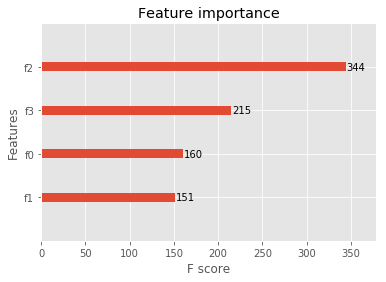

In [145]:
xgb.plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Observamos que las variables son automáticamente llamadas de acuerdo al indice que toman en nuestra matriz de datos, desde f0 hasta f3. Así, tenemos que XGBoost nos ofrece una forma de selección de atributos en un modelo; en este caso, la variable *supplier_votes* (segunda variable en nuestro conjunto de datos) obtiene una mayor importancia en la construcción del modelo que el resto de variables.

### Guardar el modelo para predicciones futuras
---
Nos puede interesar guardar el modelo creado para conocer la clasificación de nuevas observaciones:

In [146]:
from sklearn.externals import joblib

joblib.dump(model_xgb, 'model_xgb.pkl', compress=True)

['model_xgb.pkl']

### Conclusión
---
Atendiendo a la precisión obtenida por el modelo XGBoost obtenemos que sólo el modelo Random Forest aplicando optimización de sus parámetros (Grid Search) y validación cruzada obtiene una tasa de clasificación correcta (fracción de predicciones correctas en el test) mayor; usando RF un total de 100 árboles y 20 árboles XGBoost. Esto nos hace indicar la alta precisión de nuestro nuevo modelo además de su alta velocidad de ejecución. El objetivo del apéndice era hacer ver la existencia del modelo XGBoost, un modelo muy frecuente en competiciones de análisis de datos (tanto problemas de clasificación como regresión), y como hemos dicho anteriormente, buscando la mejor combinación de los parámetros posibles obtendríamos un mejor modelo.